# Ex8 - Transformação de visão e de projeção

Nesta atividade, vocês vão exercitar os conceitos de transformação de visão e de projeção. Para evitar erros de execução, utilize apenas uma célula de código para cada parte desta atividade. O teste de profundidade deve estar ativado em todos os exercícios.

### Parte 1 - Transformação de visão

Continuando com a construção do sistema solar da Atividade 7 ([EA979A_Ex07_Modelos_e_transformacoes-Gabarito](EA979A_Ex07_Modelos_e_transformacoes-Gabarito.ipynb)), adicione a renderização de Júpiter ao programa. As informações dele são fornecidas no código abaixo. Você vai perceber que o novo planeta adicionado não cabe na tela. Então, é preciso realizar algumas transformações para visualizá-lo. Para isso, crie uma matriz de visão e trate os eventos das setas do teclado para deslocar, simultaneamente, os parâmetros desta matriz (o ponto de visão e a posição da câmera) na direção da tecla pressionada. Ou seja, as setas esquerda e direita deslocam estes parâmetros no eixo x, e as setas 'para cima' e 'para baixo' deslocam eles no eixo y. Além disso, utilize as teclas + e - para alterar uma transformação global que, respectivamente, aumenta e diminui o tamanho de todos os objetos renderizados. A imagem abaixo mostram a aparência esperada com a adição de Júpiter. Comente o resultado obtido ao mudar os parâmetros de visão. O notebook ([29_Transformacao_visao](29_Transformacao_visao.ipynb)) exemplifica algumas formas de como criar e utilizar a matriz de visão.


<td><img src='cg/images/ex8_solar_system_3.png' style="width:300px">

Below we add the planet Jupiter to our solar system model from Ex07. To compensate for our orthogonal projection being of the same volume as the rendering volume, we apply a global Transformation to scale all the objects to fit in the window. This does not affect the relative scale of the objects, because we also apply a scale transformation based on each object's radius to maintain the relative aspect-ratio. To move the view, we update the camera's view point (self.cameraCenter) and position (self.cameraEye) with the same variables (self.cameraX and self.cameraY). This way, with the arrow keys, the solar system moves in the window instead of staying centralized. To "zoom" in and out, we update the self.globalTransform (mentioned above) with the desired rescaling of the image by updating the self.scale variable. 

In [1]:
import glm
import time
import math
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer
from cg.models.SphereMesh_v1 import SphereMesh
from cg.models.OrbitPolygon import OrbitPolygon

AU = 1.496E8
planet_scale_factor = 1500.0
moon_scale_factor = planet_scale_factor * 0.05
sun_scale_factor = 50

# Sun information Class
class SunInfo:
    def __init__(self, color, diameter):
        
        self.color = color
        self.diameter = (diameter / AU) * sun_scale_factor
        self.radius = self.diameter / 2.0

# Planet information Class
class PlanetInfo:
    def __init__(self, color, diameter, orbitalPeriod, orbitalInclination, orbitSemiMajorAxis, orbitSemiMinorAxis, orbitFocus):
        
        earth_days = 365.2
        
        self.color = color
        self.diameter = (diameter / AU) * planet_scale_factor
        self.radius = self.diameter / 2.0
        self.velocity = earth_days / orbitalPeriod
        
        self.orbitalPeriod = orbitalPeriod
        self.orbitalInclination = orbitalInclination 
        self.orbitSemiMajorAxis = orbitSemiMajorAxis
        self.orbitSemiMinorAxis = orbitSemiMinorAxis
        self.orbitFocus = orbitFocus

# creat dict with sun, planet, and moon info
PlanetarySheet = {
       'sun': SunInfo(np.array([1.00, 1.00, 0.00, 1.0]), 1391900),
       'earth': PlanetInfo(np.array([0.61, 0.79, 0.37, 1.0]), 12742, 365.2, 1.57, 1.0027, 1.0025, 0.0167),
       'moon': PlanetInfo(np.array([0.50, 0.50, 0.50, 1.0]), 3475, 27.3, 5.1, 0.0025718 * moon_scale_factor, 0.0021479 * moon_scale_factor, 0.00014537),
       'jupiter': PlanetInfo(np.array([0.83, 0.67, 0.53, 1.0]), 142984, 4331, 0.32, 5.2073, 5.2010, 0.2520)
       }

# Graphic information class
class GraphicObject:
    def __init__(self):
        self.model = None
        self.renderer = None
        self.modelMatrix = glm.mat4()
        self.color = np.array([1.0, 1.0, 1.0, 1.0])

        
class MyWidget(QtOpenGL.QGLWidget):

    def initializeGL(self):
        
        self.cameraX = 0.0
        self.cameraY = 0.0
        self.scale = 0.1
        
        # create a projection with the same volume as the rendering volume
        self.orthoMatrix = glm.ortho(-1, 1, -1, 1, 0, 2)
        
        # define global transformation
        # objects do not fit in the rendering volume in there original size 
        # So they must be resized to be smaller
        self.globalTransform = glm.scale(glm.mat4(), glm.vec3(self.scale, self.scale, self.scale))
        
        # create Simple Shader Programcria um shader program simples     
        self.shaderProgram = SimpleShaderProgram()
        
        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # creates spheric triangle mech for the sun, moon, and planet
        sphere_mesh = SphereMesh(1.0, 30, 30)
        sphere_renderer = ModelRenderer(sphere_mesh.getVertexPositions(), vertex_indices=sphere_mesh.getVertexIndices())
        sphere_renderer.setVertexPositionLoc(position_loc)
        
        # create object to store planet orbit info
        planet_info = PlanetarySheet['earth']
        self.earthOrbit = GraphicObject()
        self.earthOrbit.model = OrbitPolygon(planet_info.orbitSemiMajorAxis, planet_info.orbitSemiMinorAxis, planet_info.orbitFocus, 50)
        self.earthOrbit.renderer = ModelRenderer(self.earthOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.earthOrbit.renderer.setVertexPositionLoc(position_loc)
        self.earthOrbit.color = planet_info.color
        self.earthOrbit.modelMatrix = self.globalTransform 
    
        # creat object to store planet info
        self.earthPlanet = GraphicObject()
        self.earthPlanet.model = sphere_mesh
        self.earthPlanet.renderer = sphere_renderer
        self.earthPlanet.color = PlanetarySheet['earth'].color
        
        # create object to store Sun info
        self.sun = GraphicObject()
        self.sun.model = sphere_mesh
        self.sun.renderer = sphere_renderer
        self.sun.color = PlanetarySheet['sun'].color
        self.sun.modelMatrix = glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        # create object to store moon orbit info
        moon_info = PlanetarySheet['moon']
        self.moonOrbit = GraphicObject()
        self.moonOrbit.model = OrbitPolygon(moon_info.orbitSemiMajorAxis, moon_info.orbitSemiMinorAxis, moon_info.orbitFocus, 50)
        self.moonOrbit.renderer = ModelRenderer(self.moonOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.moonOrbit.renderer.setVertexPositionLoc(position_loc)
        self.moonOrbit.color = moon_info.color
        self.moonOrbit.modelMatrix = self.globalTransform 
    
        # create object to store moon info
        self.moon = GraphicObject()
        self.moon.model = sphere_mesh
        self.moon.renderer = sphere_renderer
        self.moon.color = PlanetarySheet['moon'].color
        
        #create object to store jupiter orbit info
        jup_info = PlanetarySheet['jupiter']
        self.jupOrbit = GraphicObject()
        self.jupOrbit.model = OrbitPolygon(jup_info.orbitSemiMajorAxis, jup_info.orbitSemiMinorAxis, jup_info.orbitFocus, 50)
        self.jupOrbit.renderer = ModelRenderer(self.jupOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.jupOrbit.renderer.setVertexPositionLoc(position_loc)
        self.jupOrbit.color = jup_info.color
        self.jupOrbit.modelMatrix = self.globalTransform 
    
        # create object to store jupiter info
        self.jupPlanet = GraphicObject()
        self.jupPlanet.model = sphere_mesh
        self.jupPlanet.renderer = sphere_renderer
        self.jupPlanet.color = PlanetarySheet['jupiter'].color
        
        # stores program start time
        self.startTime = time.time()
    
    def paintGL(self):
        
        # set background color
        gl.glClearColor(0, 0, 0, 1)
        
        # clean background with the specified color
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate depth test
        gl.glEnable(gl.GL_DEPTH_TEST);
        
        # calculate the current execution time
        self.currentTime = time.time()
        time_elapsed = self.currentTime - self.startTime
        
        # activate shader program
        self.shaderProgram.bind()

        # position the camera at z =1, looking towards negative z axis
        self.cameraEye   = glm.vec3(self.cameraX, self.cameraY, 1.0) # camera position
        self.cameraCenter = glm.vec3(self.cameraX, self.cameraY, -1.0) # point of view (to where the camera is looking) 
        self.cameraUp    = glm.vec3(0.0, 1.0, 0.0) # camera orientation vector
        self.viewMatrix = glm.lookAt(self.cameraEye, self.cameraCenter, self.cameraUp)
         
        # update scale
        self.globalTransform = glm.scale(glm.mat4(), glm.vec3(self.scale, self.scale, self.scale))
        
        # render objects 
        self.renderSun()
        self.renderEarthOrbit()
        self.renderEarthPlanet(time_elapsed)
        self.renderMoonOrbit(time_elapsed)
        self.renderMoon(time_elapsed)
        self.renderJupOrbit()
        self.renderJupPlanet(time_elapsed)
        
        # deactivate shader program
        self.shaderProgram.release()
        
        # re-call paintGL
        self.update()
    
    def resizeGL(self, width, height):

        # update rendering area to be the entire window
        gl.glViewport(0, 0, width, height)
        
    def renderSun(self):
        
        #sun size
        scale_sun_size = glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        #sun model matrix
        self.sun.modelMatrix = self.globalTransform * scale_sun_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.sun.modelMatrix)
        self.shaderProgram.setUniformColor(self.sun.color)
        
        # render the Sun
        self.sun.renderer.render()
    
    def renderEarthOrbit(self):
        
        #set model
        self.earthOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Earth Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.earthOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthOrbit.color)
        
        # render earth orbit
        self.earthOrbit.renderer.render()
        
    def renderEarthPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        planet_info = PlanetarySheet['earth']
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(planet_info.radius, planet_info.radius, planet_info.radius))
        
        # calculate final planet transformation matrix
        self.earthPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.earthPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthPlanet.color)
        
        # render the planet
        self.earthPlanet.renderer.render()
    
    def renderMoonOrbit(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon orbit position on earth orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) #get new coordinates for translation
        
        transl_moonOrbit_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0)) #calculate translation matrix
        self.moonOrbit.modelMatrix = self.globalTransform * transl_moonOrbit_pos #calulate new position 
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.moonOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.moonOrbit.color)
        
        # render the moon orbit
        self.moonOrbit.renderer.render()
        
    
    def renderMoon(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon position on moon orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) # new coordinates due to orbit translation
        x1, y1 = self.moonOrbit.model.getPositionAt(angle * moon_info.velocity) # new coordinates due to orbit around earth
        
        # add both translations into one
        x= x + x1
        y = y + y1
        
        # create translation matrix to update moon position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep moon at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(moon_info.radius, moon_info.radius, moon_info.radius))
        
        # calculate final moon transformation matrix
        self.moon.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the moon color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.moon.modelMatrix)
        self.shaderProgram.setUniformColor(self.moon.color)
        
        # render the planet
        self.moon.renderer.render()

        
    def renderJupOrbit(self):
        
        #set model
        self.jupOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Jupiter Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.jupOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupOrbit.color)
        
        # render earth orbit
        self.jupOrbit.renderer.render()
        
        
    def renderJupPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        jup_info = PlanetarySheet['jupiter']
        x, y = self.jupOrbit.model.getPositionAt(angle * jup_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(jup_info.radius, jup_info.radius, jup_info.radius))
        
        # calculate final planet transformation matrix
        self.jupPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.jupPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupPlanet.color)
        
        # render the planet
        self.jupPlanet.renderer.render()
    
    
    # Key Press Event descriptions
    def keyPressEvent(self, event):
        super(MyWidget, self).keyPressEvent(event)
        
        if event.key() == (QtCore.Qt.Key_Up):
            self.cameraY -= 0.1
        if event.key() == (QtCore.Qt.Key_Down):
            self.cameraY += 0.1
        if event.key() == (QtCore.Qt.Key_Left):
            self.cameraX += 0.1
        if event.key() == (QtCore.Qt.Key_Right):
            self.cameraX -= 0.1
        if event.key() == (QtCore.Qt.Key_Plus):
            self.scale += 0.05
        if event.key() == (QtCore.Qt.Key_Minus):
            self.scale -= 0.05
    
           
def main():
    import sys

    #create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(600, 600)
    w.setWindowTitle('Solar System')
    w.show()
    
    output = app.exec_()
    sys.exit(output)
    
if __name__ == '__main__':
    main()

SystemExit: 0

C:\Users\Andre\Anaconda2\envs\EA979\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


The above code generates, as expected, the following window, with Jupiter and arrow key functions:

### Parte 2 - Transformações de projeção

Adicione na renderização realizada na Parte 1 dois quadrados com cores diferentes ([27_Quadrado_com_transformacoes](27_Quadrado_com_transformacoes.ipynb)). O primeiro tem tamanho 25x25 e deve ser transladado para a posição (0, 0, -15). O segundo tem tamanho 30x30 e deve ser transladado para a posição (0, 0, -20). Renderize esta cena de duas formas. Uma delas utilizando uma matriz de projeção ortográfica e a outra utilizando uma matriz de projeção perspectiva. Realiza os ajustes necessários somente nos parâmetros das matrizes de visão e de projeção destas duas cenas para cada cena renderizar uma imagem semelhante à imagem abaixo (com os quadrados centrados na tela e com as bordas dos quadrados longe das bordas da janela). O ponto de visão está fixo na posição (0, 0, -1). Diferente da Parte 1, a matriz de transformação global deve ser uma matriz identidade e não há tratamento de eventos do teclado. As duas cenas podem ser renderizadas por um único programa através de múltiplos viewports ou por dois programas distintos. Comente como você chegou nos valores dos parâmetros das matrizes para obter as cenas pedidas. Os notebooks ([30_Transformacao_projecao_ortogonal](30_Transformacao_projecao_ortogonal.ipynb)) e ([31_Transformacao_projecao_perspectiva](31_Transformacao_projecao_perspectiva.ipynb)) exemplificam algumas formas de como criar e utilizar as matrizes de projeção.


<td><img src='cg/images/ex8_solar_system_4.png' style="width:400px">

### Orthogonal Projection:
Now, instead of fitting the system within the window by downscaling with a global Transformation, we set self.globalTransform to an identity matrix and include an Orthogonal Projection matrix (self.orthoMatrix). By projecting in a larger volume than the rendering volume, the objects fit in the window. What is very important in this exercise and with projections in general, is to set the near and far planes accordingly. For example, in this case, our "background" squares are placed at z= -20 and -15 and our camera at z=1. This means that we need at least a far plane of 21 to capture both squares. We must also take care to apply the transformations in the correct order (Model,View,Projection).

In [3]:
import glm
import time
import math
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer
from cg.models.SphereMesh_v1 import SphereMesh
from cg.models.SquareMesh_v1 import SquareMesh
from cg.models.OrbitPolygon import OrbitPolygon

AU = 1.496E8
planet_scale_factor = 1500.0
moon_scale_factor = planet_scale_factor * 0.05
sun_scale_factor = 50

# Sun information Class
class SunInfo:
    def __init__(self, color, diameter):
        
        self.color = color
        self.diameter = (diameter / AU) * sun_scale_factor
        self.radius = self.diameter / 2.0

# Planet information Class
class PlanetInfo:
    def __init__(self, color, diameter, orbitalPeriod, orbitalInclination, orbitSemiMajorAxis, orbitSemiMinorAxis, orbitFocus):
        
        earth_days = 365.2
        
        self.color = color
        self.diameter = (diameter / AU) * planet_scale_factor
        self.radius = self.diameter / 2.0
        self.velocity = earth_days / orbitalPeriod
        
        self.orbitalPeriod = orbitalPeriod
        self.orbitalInclination = orbitalInclination 
        self.orbitSemiMajorAxis = orbitSemiMajorAxis
        self.orbitSemiMinorAxis = orbitSemiMinorAxis
        self.orbitFocus = orbitFocus

# creat dict with sun, planet, and moon info
PlanetarySheet = {
       'sun': SunInfo(np.array([1.00, 1.00, 0.00, 1.0]), 1391900),
       'earth': PlanetInfo(np.array([0.61, 0.79, 0.37, 1.0]), 12742, 365.2, 1.57, 1.0027, 1.0025, 0.0167),
       'moon': PlanetInfo(np.array([0.50, 0.50, 0.50, 1.0]), 3475, 27.3, 5.1, 0.0025718 * moon_scale_factor, 0.0021479 * moon_scale_factor, 0.00014537),
       'jupiter': PlanetInfo(np.array([0.83, 0.67, 0.53, 1.0]), 142984, 4331, 0.32, 5.2073, 5.2010, 0.2520)
       }

# Graphic information class
class GraphicObject:
    def __init__(self):
        self.model = None
        self.renderer = None
        self.modelMatrix = glm.mat4()
        self.color = np.array([1.0, 1.0, 1.0, 1.0])

        
class MyWidget(QtOpenGL.QGLWidget):

    def initializeGL(self):
        
        # create square mesh
        square_mesh1 = SquareMesh(25,25, 1 ,1)
        square_mesh2 = SquareMesh(30,30, 1, 1)
        
        # creat object responsible for loading objects into GPU and rendering
        self.innerSquareRenderer = ModelRenderer(square_mesh1.getVertexPositions(), vertex_indices=square_mesh1.getVertexIndices())
        self.outerSquareRenderer = ModelRenderer(square_mesh2.getVertexPositions(), vertex_indices=square_mesh2.getVertexIndices())
        
        # create a projection with the same volume as the rendering volume
        self.orthoMatrix = glm.ortho(-16, 16, -16, 16, 0, 21)
        
        # define global transformation
        # objects do not fit in the rendering volume in there original size 
        # So they must be resized to be smaller
        self.globalTransform = glm.scale(glm.mat4(), glm.vec3(1, 1, 1))
        
        # create Simple Shader Programcria um shader program simples     
        self.shaderProgram = SimpleShaderProgram()
        
        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        self.innerSquareRenderer.setVertexPositionLoc(position_loc)
        self.outerSquareRenderer.setVertexPositionLoc(position_loc)
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # creates spheric triangle mech for the sun, moon, and planet
        sphere_mesh = SphereMesh(1.0, 30, 30)
        sphere_renderer = ModelRenderer(sphere_mesh.getVertexPositions(), vertex_indices=sphere_mesh.getVertexIndices())
        sphere_renderer.setVertexPositionLoc(position_loc)
        
        # create object to store planet orbit info
        planet_info = PlanetarySheet['earth']
        self.earthOrbit = GraphicObject()
        self.earthOrbit.model = OrbitPolygon(planet_info.orbitSemiMajorAxis, planet_info.orbitSemiMinorAxis, planet_info.orbitFocus, 50)
        self.earthOrbit.renderer = ModelRenderer(self.earthOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.earthOrbit.renderer.setVertexPositionLoc(position_loc)
        self.earthOrbit.color = planet_info.color
        self.earthOrbit.modelMatrix = self.globalTransform 
    
        # creat object to store planet info
        self.earthPlanet = GraphicObject()
        self.earthPlanet.model = sphere_mesh
        self.earthPlanet.renderer = sphere_renderer
        self.earthPlanet.color = PlanetarySheet['earth'].color
        
        # create object to store Sun info
        self.sun = GraphicObject()
        self.sun.model = sphere_mesh
        self.sun.renderer = sphere_renderer
        self.sun.color = PlanetarySheet['sun'].color
        self.sun.modelMatrix = glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        # create object to store moon orbit info
        moon_info = PlanetarySheet['moon']
        self.moonOrbit = GraphicObject()
        self.moonOrbit.model = OrbitPolygon(moon_info.orbitSemiMajorAxis, moon_info.orbitSemiMinorAxis, moon_info.orbitFocus, 50)
        self.moonOrbit.renderer = ModelRenderer(self.moonOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.moonOrbit.renderer.setVertexPositionLoc(position_loc)
        self.moonOrbit.color = moon_info.color
        self.moonOrbit.modelMatrix = self.globalTransform 
    
        # create object to store moon info
        self.moon = GraphicObject()
        self.moon.model = sphere_mesh
        self.moon.renderer = sphere_renderer
        self.moon.color = PlanetarySheet['moon'].color
        
        #create object to store jupiter orbit info
        jup_info = PlanetarySheet['jupiter']
        self.jupOrbit = GraphicObject()
        self.jupOrbit.model = OrbitPolygon(jup_info.orbitSemiMajorAxis, jup_info.orbitSemiMinorAxis, jup_info.orbitFocus, 50)
        self.jupOrbit.renderer = ModelRenderer(self.jupOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.jupOrbit.renderer.setVertexPositionLoc(position_loc)
        self.jupOrbit.color = jup_info.color
        self.jupOrbit.modelMatrix = self.globalTransform 
    
        # create object to store jupiter info
        self.jupPlanet = GraphicObject()
        self.jupPlanet.model = sphere_mesh
        self.jupPlanet.renderer = sphere_renderer
        self.jupPlanet.color = PlanetarySheet['jupiter'].color
        
        # stores program start time
        self.startTime = time.time()
    
    def paintGL(self):
        
        # set background color
        gl.glClearColor(1, 1, 1, 1)
        
        # clean background with the specified color
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate depth test
        gl.glEnable(gl.GL_DEPTH_TEST);
        
        # calculate the current execution time
        self.currentTime = time.time()
        time_elapsed = self.currentTime - self.startTime
        
        # activate shader program
        self.shaderProgram.bind()

        # position camera at z=1 looking at negative z axis
        self.cameraEye   = glm.vec3(0.0, 0.0, 1.0) # camera position
        self.cameraCenter = glm.vec3(0.0, 0.0, -1.0) # point of vision (to where the camera is looking) 
        self.cameraUp    = glm.vec3(0.0, 1.0, 0.0) # vetor 'pra cima'
        self.viewMatrix = glm.lookAt(self.cameraEye, self.cameraCenter, self.cameraUp)
         
        
        # render objects 
        self.renderSun()
        self.renderEarthOrbit()
        self.renderEarthPlanet(time_elapsed)
        self.renderMoonOrbit(time_elapsed)
        self.renderMoon(time_elapsed)
        self.renderJupOrbit()
        self.renderJupPlanet(time_elapsed)
        self.renderInnerSquare()
        self.renderOuterSquare()
        
        # deactivate shader program
        self.shaderProgram.release()
        
        # re-call paintGL
        self.update()
    
    def resizeGL(self, width, height):

        # update rendering area to be the entire window
        gl.glViewport(0, 0, width, height)
        
    def renderSun(self):

        #sun size
        scale_sun_size=glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        #sun model matrix
        self.sun.modelMatrix = self.globalTransform * scale_sun_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix( self.orthoMatrix * self.viewMatrix * self.sun.modelMatrix)
        self.shaderProgram.setUniformColor(self.sun.color)
        
        # render the Sun
        self.sun.renderer.render()
    
    
    def renderEarthOrbit(self):
        
        #set model
        self.earthOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Earth Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.earthOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthOrbit.color)
        
        # render earth orbit
        self.earthOrbit.renderer.render()
        
    def renderEarthPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        planet_info = PlanetarySheet['earth']
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(planet_info.radius, planet_info.radius, planet_info.radius))
        
        # calculate final planet transformation matrix
        self.earthPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.earthPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthPlanet.color)
        
        # render the planet
        self.earthPlanet.renderer.render()
    
    def renderMoonOrbit(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon orbit position on earth orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) #get new coordinates for translation
        
        transl_moonOrbit_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0)) #calculate translation matrix
        self.moonOrbit.modelMatrix = self.globalTransform * transl_moonOrbit_pos #calulate new position 
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.moonOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.moonOrbit.color)
        
        # render the moon orbit
        self.moonOrbit.renderer.render()
        
    
    def renderMoon(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon position on moon orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) # new coordinates due to orbit translation
        x1, y1 = self.moonOrbit.model.getPositionAt(angle * moon_info.velocity) # new coordinates due to orbit around earth
        
        # add both translations into one
        x= x + x1
        y = y + y1
        
        # create translation matrix to update moon position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep moon at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(moon_info.radius, moon_info.radius, moon_info.radius))
        
        # calculate final moon transformation matrix
        self.moon.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the moon color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.moon.modelMatrix)
        self.shaderProgram.setUniformColor(self.moon.color)
        
        # render the planet
        self.moon.renderer.render()

        
    def renderJupOrbit(self):
        
        #set model
        self.jupOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Jupiter Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.jupOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupOrbit.color)
        
        # render earth orbit
        self.jupOrbit.renderer.render()
        
        
    def renderJupPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        jup_info = PlanetarySheet['jupiter']
        x, y = self.jupOrbit.model.getPositionAt(angle * jup_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(jup_info.radius, jup_info.radius, jup_info.radius))
        
        # calculate final planet transformation matrix
        self.jupPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.jupPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupPlanet.color)
        
        # render the planet
        self.jupPlanet.renderer.render()
    
    def renderInnerSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -14.999))
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.0, 0.0, 1.0], dtype=np.float32))
        self.innerSquareRenderer.render()
        
           
    def renderOuterSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -19.999)) 
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.5, 0.0, 1.0], dtype=np.float32))
        self.outerSquareRenderer.render()
        
        
def main():
    import sys

    #create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(600, 600)
    w.setWindowTitle('Solar System')
    w.show()
    
    output = app.exec_()
    sys.exit(output)
    
if __name__ == '__main__':
    main()

SystemExit: 0

The above code, as expected, generates the following window:  

### Perspective Projection:
Now, we want to visualize the same window, but through a Perspective projection instead of an orthogonal projection. We maintain the global transformation as an Identity and must tune the self.perspectiveMatrix parameters apropriately. The near and far planes follow the same logic as above. However, instead of a rendering volume, we now must set a rendering angle. By trial and error we reached an acceptable value. But just the parameter adjustment is not enough. For us to visualize the squares and the entire solar system without distortion, we must change the camera position to a "higher" point. The view point (to where the camera is pointed) is always the same, but we place the camera further from the objects to be able to view the entire scene.

In [4]:
import glm
import time
import math
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer
from cg.models.SphereMesh_v1 import SphereMesh
from cg.models.SquareMesh_v1 import SquareMesh
from cg.models.OrbitPolygon import OrbitPolygon

AU = 1.496E8
planet_scale_factor = 1500.0
moon_scale_factor = planet_scale_factor * 0.05
sun_scale_factor = 50

# Sun information Class
class SunInfo:
    def __init__(self, color, diameter):
        
        self.color = color
        self.diameter = (diameter / AU) * sun_scale_factor
        self.radius = self.diameter / 2.0

# Planet information Class
class PlanetInfo:
    def __init__(self, color, diameter, orbitalPeriod, orbitalInclination, orbitSemiMajorAxis, orbitSemiMinorAxis, orbitFocus):
        
        earth_days = 365.2
        
        self.color = color
        self.diameter = (diameter / AU) * planet_scale_factor
        self.radius = self.diameter / 2.0
        self.velocity = earth_days / orbitalPeriod
        
        self.orbitalPeriod = orbitalPeriod
        self.orbitalInclination = orbitalInclination 
        self.orbitSemiMajorAxis = orbitSemiMajorAxis
        self.orbitSemiMinorAxis = orbitSemiMinorAxis
        self.orbitFocus = orbitFocus

# creat dict with sun, planet, and moon info
PlanetarySheet = {
       'sun': SunInfo(np.array([1.00, 1.00, 0.00, 1.0]), 1391900),
       'earth': PlanetInfo(np.array([0.61, 0.79, 0.37, 1.0]), 12742, 365.2, 1.57, 1.0027, 1.0025, 0.0167),
       'moon': PlanetInfo(np.array([0.50, 0.50, 0.50, 1.0]), 3475, 27.3, 5.1, 0.0025718 * moon_scale_factor, 0.0021479 * moon_scale_factor, 0.00014537),
       'jupiter': PlanetInfo(np.array([0.83, 0.67, 0.53, 1.0]), 142984, 4331, 0.32, 5.2073, 5.2010, 0.2520)
       }

# Graphic information class
class GraphicObject:
    def __init__(self):
        self.model = None
        self.renderer = None
        self.modelMatrix = glm.mat4()
        self.color = np.array([1.0, 1.0, 1.0, 1.0])

        
class MyWidget(QtOpenGL.QGLWidget):

    def initializeGL(self):
        
        # create square mesh
        square_mesh1 = SquareMesh(25, 25, 1, 1)
        square_mesh2 = SquareMesh(30, 30, 1, 1)
        
        # creat object responsible for loading objects into GPU and rendering
        self.innerSquareRenderer = ModelRenderer(square_mesh1.getVertexPositions(), vertex_indices=square_mesh1.getVertexIndices())
        self.outerSquareRenderer = ModelRenderer(square_mesh2.getVertexPositions(), vertex_indices=square_mesh2.getVertexIndices())
        
        # define global transformation
        # objects do not fit in the rendering volume in there original size 
        # So they must be resized to be smaller
        self.globalTransform = glm.scale(glm.mat4(), glm.vec3(1, 1, 1)) #identity
        
        # create Simple Shader Programcria um shader program simples     
        self.shaderProgram = SimpleShaderProgram()
        
        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        self.innerSquareRenderer.setVertexPositionLoc(position_loc)
        self.outerSquareRenderer.setVertexPositionLoc(position_loc)
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # creates spheric triangle mech for the sun, moon, and planet
        sphere_mesh = SphereMesh(1.0, 30, 30)
        sphere_renderer = ModelRenderer(sphere_mesh.getVertexPositions(), vertex_indices=sphere_mesh.getVertexIndices())
        sphere_renderer.setVertexPositionLoc(position_loc)
        
        # create object to store planet orbit info
        planet_info = PlanetarySheet['earth']
        self.earthOrbit = GraphicObject()
        self.earthOrbit.model = OrbitPolygon(planet_info.orbitSemiMajorAxis, planet_info.orbitSemiMinorAxis, planet_info.orbitFocus, 50)
        self.earthOrbit.renderer = ModelRenderer(self.earthOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.earthOrbit.renderer.setVertexPositionLoc(position_loc)
        self.earthOrbit.color = planet_info.color
        self.earthOrbit.modelMatrix = self.globalTransform 
    
        # creat object to store planet info
        self.earthPlanet = GraphicObject()
        self.earthPlanet.model = sphere_mesh
        self.earthPlanet.renderer = sphere_renderer
        self.earthPlanet.color = PlanetarySheet['earth'].color
        
        # create object to store Sun info
        self.sun = GraphicObject()
        self.sun.model = sphere_mesh
        self.sun.renderer = sphere_renderer
        self.sun.color = PlanetarySheet['sun'].color
        self.sun.modelMatrix = glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        # create object to store moon orbit info
        moon_info = PlanetarySheet['moon']
        self.moonOrbit = GraphicObject()
        self.moonOrbit.model = OrbitPolygon(moon_info.orbitSemiMajorAxis, moon_info.orbitSemiMinorAxis, moon_info.orbitFocus, 50)
        self.moonOrbit.renderer = ModelRenderer(self.moonOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.moonOrbit.renderer.setVertexPositionLoc(position_loc)
        self.moonOrbit.color = moon_info.color
        self.moonOrbit.modelMatrix = self.globalTransform 
    
        # create object to store moon info
        self.moon = GraphicObject()
        self.moon.model = sphere_mesh
        self.moon.renderer = sphere_renderer
        self.moon.color = PlanetarySheet['moon'].color
        
        #create object to store jupiter orbit info
        jup_info = PlanetarySheet['jupiter']
        self.jupOrbit = GraphicObject()
        self.jupOrbit.model = OrbitPolygon(jup_info.orbitSemiMajorAxis, jup_info.orbitSemiMinorAxis, jup_info.orbitFocus, 50)
        self.jupOrbit.renderer = ModelRenderer(self.jupOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.jupOrbit.renderer.setVertexPositionLoc(position_loc)
        self.jupOrbit.color = jup_info.color
        self.jupOrbit.modelMatrix = self.globalTransform 
    
        # create object to store jupiter info
        self.jupPlanet = GraphicObject()
        self.jupPlanet.model = sphere_mesh
        self.jupPlanet.renderer = sphere_renderer
        self.jupPlanet.color = PlanetarySheet['jupiter'].color
        
        # stores program start time
        self.startTime = time.time()
    
    def paintGL(self):
        
        # set background color
        gl.glClearColor(1, 1, 1, 1)
        
        # clean background with the specified color
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate depth test
        gl.glEnable(gl.GL_DEPTH_TEST);
        
        # calculate the current execution time
        self.currentTime = time.time()
        time_elapsed = self.currentTime - self.startTime
        
        # activate shader program
        self.shaderProgram.bind()

        # position camera at z=30 looking at negative z axis
        self.cameraEye   = glm.vec3(0.0, 0.0, 30.0) # camera position
        self.cameraCenter = glm.vec3(0.0, 0.0, -1.0) # point of vision (to where the camera is pointing) 
        self.cameraUp    = glm.vec3(0.0, 1.0, 0.0) # vetor 'pra cima'
        self.viewMatrix = glm.lookAt(self.cameraEye, self.cameraCenter, self.cameraUp)
         
        # create a projection
        # radians is field of view 
        # aspect ratio is causes "rotation"
        # first number is close plane distance
        #second number is far plane distance
        self.perspectiveMatrix = glm.perspective(glm.radians(45), self.aspectRatio, 1, 300)
        
        # render objects 
        self.renderSun()
        self.renderEarthOrbit()
        self.renderEarthPlanet(time_elapsed)
        self.renderMoonOrbit(time_elapsed)
        self.renderMoon(time_elapsed)
        self.renderJupOrbit()
        self.renderJupPlanet(time_elapsed)
        self.renderInnerSquare()
        self.renderOuterSquare()
        
        # deactivate shader program
        self.shaderProgram.release()
        
        # re-call paintGL
        self.update()
    
    def resizeGL(self, width, height):

        # update rendering area to be the entire window
        gl.glViewport(0, 0, width, height)
        self.aspectRatio = int(width) / height #change here to rotate view of solar system 
        
    def renderSun(self):
        
        #sun size
        scale_sun_size=glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        #sun model matrix
        self.sun.modelMatrix = self.globalTransform * scale_sun_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix( self.perspectiveMatrix * self.viewMatrix * self.sun.modelMatrix)
        self.shaderProgram.setUniformColor(self.sun.color)
        
        # render the Sun
        self.sun.renderer.render()
    
    
    def renderEarthOrbit(self):
        
        #set model
        self.earthOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Earth Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.earthOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthOrbit.color)
        
        # render earth orbit
        self.earthOrbit.renderer.render()
        
    def renderEarthPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        planet_info = PlanetarySheet['earth']
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(planet_info.radius, planet_info.radius, planet_info.radius))
        
        # calculate final planet transformation matrix
        self.earthPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.earthPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthPlanet.color)
        
        # render the planet
        self.earthPlanet.renderer.render()
    
    def renderMoonOrbit(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon orbit position on earth orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) #get new coordinates for translation
        
        transl_moonOrbit_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0)) #calculate translation matrix
        self.moonOrbit.modelMatrix = self.globalTransform * transl_moonOrbit_pos #calulate new position 
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.moonOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.moonOrbit.color)
        
        # render the moon orbit
        self.moonOrbit.renderer.render()
        
    
    def renderMoon(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon position on moon orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) # new coordinates due to orbit translation
        x1, y1 = self.moonOrbit.model.getPositionAt(angle * moon_info.velocity) # new coordinates due to orbit around earth
        
        # add both translations into one
        x= x + x1
        y = y + y1
        
        # create translation matrix to update moon position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep moon at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(moon_info.radius, moon_info.radius, moon_info.radius))
        
        # calculate final moon transformation matrix
        self.moon.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the moon color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.moon.modelMatrix)
        self.shaderProgram.setUniformColor(self.moon.color)
        
        # render the planet
        self.moon.renderer.render()

        
    def renderJupOrbit(self):
        
        #set model
        self.jupOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Jupiter Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.jupOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupOrbit.color)
        
        # render earth orbit
        self.jupOrbit.renderer.render()
        
        
    def renderJupPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        jup_info = PlanetarySheet['jupiter']
        x, y = self.jupOrbit.model.getPositionAt(angle * jup_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(jup_info.radius, jup_info.radius, jup_info.radius))
        
        # calculate final planet transformation matrix
        self.jupPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.jupPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupPlanet.color)
        
        # render the planet
        self.jupPlanet.renderer.render()
    
    def renderInnerSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -14.999))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.0, 0.0, 1.0], dtype=np.float32))
        self.innerSquareRenderer.render()
        
        
           
    def renderOuterSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -19.999))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.5, 0.0, 1.0], dtype=np.float32))
        self.outerSquareRenderer.render()
        
        
        
def main():
    import sys

    #create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(600, 600)
    w.setWindowTitle('Solar System')
    w.show()
    
    output = app.exec_()
    sys.exit(output)
    
if __name__ == '__main__':
    main()

SystemExit: 0

The above code generates, as expected, the following window:

### Parte 3 - Transformações de visão e de projeção

Utilizando o código da Parte 2, trate os eventos das setas do teclado para alterar apenas a posição da matriz de visão (o ponto de visão está fixo na posição (0, 0, -1)). Desloque o parâmetro de posição da câmera desta matriz na direção da tecla pressionada. Ou seja, as setas esquerda e direita deslocam no eixo x, e as setas 'para cima' e 'para baixo' deslocam no eixo y. Além disso, utilize as teclas + e - para, respectivamente, incrementar e decrementar a componente z da posição da câmera. As imagens abaixo mostram o efeito obtido quando a posição da câmera é transladada para a esquerda. Comente as diferenças entre as imagens renderizadas com a projeção perspectiva e com a projeção ortográfica ao mudar a posição da câmera. Os notebooks ([29_Transformacao_visao](29_Transformacao_visao.ipynb)), ([30_Transformacao_projecao_ortogonal](30_Transformacao_projecao_ortogonal.ipynb)) e ([31_Transformacao_projecao_perspectiva](31_Transformacao_projecao_perspectiva.ipynb)) exemplificam algumas formas de como criar e utilizar as matrizes de visão e de projeção.

<table>
    <tr>
        <td> Projeção perspectiva <img src='cg/images/ex8_solar_system_5.png' style="width:400px"> </td>
        <td> Projeção ortográfica <img src='cg/images/ex8_solar_system_6.png' style="width:400px"></td>
    </tr>
</table>

### Orthogonal Projection + viewMatrix key control:
Now let's return to the orthogonal projection code above (from part 2), adding key control to the camera position. We do this by incrementing/decrementing the variables self.cameraX, self.cameraY, and self.cameraY, which are the self.cameraEye vector components. This way, we can move the camera and see what this does to the scene. This is the only change. The global transformation and the orthogonal projection remain the same.

In [7]:
import glm
import time
import math
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer
from cg.models.SphereMesh_v1 import SphereMesh
from cg.models.SquareMesh_v1 import SquareMesh
from cg.models.OrbitPolygon import OrbitPolygon

AU = 1.496E8
planet_scale_factor = 1500.0
moon_scale_factor = planet_scale_factor * 0.05
sun_scale_factor = 50

# Sun information Class
class SunInfo:
    def __init__(self, color, diameter):
        
        self.color = color
        self.diameter = (diameter / AU) * sun_scale_factor
        self.radius = self.diameter / 2.0

# Planet information Class
class PlanetInfo:
    def __init__(self, color, diameter, orbitalPeriod, orbitalInclination, orbitSemiMajorAxis, orbitSemiMinorAxis, orbitFocus):
        
        earth_days = 365.2
        
        self.color = color
        self.diameter = (diameter / AU) * planet_scale_factor
        self.radius = self.diameter / 2.0
        self.velocity = earth_days / orbitalPeriod
        
        self.orbitalPeriod = orbitalPeriod
        self.orbitalInclination = orbitalInclination 
        self.orbitSemiMajorAxis = orbitSemiMajorAxis
        self.orbitSemiMinorAxis = orbitSemiMinorAxis
        self.orbitFocus = orbitFocus

# creat dict with sun, planet, and moon info
PlanetarySheet = {
       'sun': SunInfo(np.array([1.00, 1.00, 0.00, 1.0]), 1391900),
       'earth': PlanetInfo(np.array([0.61, 0.79, 0.37, 1.0]), 12742, 365.2, 1.57, 1.0027, 1.0025, 0.0167),
       'moon': PlanetInfo(np.array([0.50, 0.50, 0.50, 1.0]), 3475, 27.3, 5.1, 0.0025718 * moon_scale_factor, 0.0021479 * moon_scale_factor, 0.00014537),
       'jupiter': PlanetInfo(np.array([0.83, 0.67, 0.53, 1.0]), 142984, 4331, 0.32, 5.2073, 5.2010, 0.2520)
       }

# Graphic information class
class GraphicObject:
    def __init__(self):
        self.model = None
        self.renderer = None
        self.modelMatrix = glm.mat4()
        self.color = np.array([1.0, 1.0, 1.0, 1.0])

        
class MyWidget(QtOpenGL.QGLWidget):

    def initializeGL(self):
        
        #initial camera position
        self.cameraX = 0.0
        self.cameraY = 0.0
        self.cameraZ = 1.0
        
        # create square mesh
        square_mesh1 = SquareMesh(25,25, 1 ,1)
        square_mesh2 = SquareMesh(30,30, 1, 1)
        
        # creat object responsible for loading objects into GPU and rendering
        self.innerSquareRenderer = ModelRenderer(square_mesh1.getVertexPositions(), vertex_indices=square_mesh1.getVertexIndices())
        self.outerSquareRenderer = ModelRenderer(square_mesh2.getVertexPositions(), vertex_indices=square_mesh2.getVertexIndices())
        
        # create a projection with the same volume as the rendering volume
        self.orthoMatrix = glm.ortho(-16, 16, -16, 16, 0, 300)
        
        # define global transformation
        # objects do not fit in the rendering volume in there original size 
        # So they must be resized to be smaller
        self.globalTransform = glm.scale(glm.mat4(), glm.vec3(1, 1, 1))
        
        # create Simple Shader Programcria um shader program simples     
        self.shaderProgram = SimpleShaderProgram()
        
        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        self.innerSquareRenderer.setVertexPositionLoc(position_loc)
        self.outerSquareRenderer.setVertexPositionLoc(position_loc)
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # creates spheric triangle mech for the sun, moon, and planet
        sphere_mesh = SphereMesh(1.0, 30, 30)
        sphere_renderer = ModelRenderer(sphere_mesh.getVertexPositions(), vertex_indices=sphere_mesh.getVertexIndices())
        sphere_renderer.setVertexPositionLoc(position_loc)
        
        # create object to store planet orbit info
        planet_info = PlanetarySheet['earth']
        self.earthOrbit = GraphicObject()
        self.earthOrbit.model = OrbitPolygon(planet_info.orbitSemiMajorAxis, planet_info.orbitSemiMinorAxis, planet_info.orbitFocus, 50)
        self.earthOrbit.renderer = ModelRenderer(self.earthOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.earthOrbit.renderer.setVertexPositionLoc(position_loc)
        self.earthOrbit.color = planet_info.color
        self.earthOrbit.modelMatrix = self.globalTransform 
    
        # creat object to store planet info
        self.earthPlanet = GraphicObject()
        self.earthPlanet.model = sphere_mesh
        self.earthPlanet.renderer = sphere_renderer
        self.earthPlanet.color = PlanetarySheet['earth'].color
        
        # create object to store Sun info
        self.sun = GraphicObject()
        self.sun.model = sphere_mesh
        self.sun.renderer = sphere_renderer
        self.sun.color = PlanetarySheet['sun'].color
        self.sun.modelMatrix = glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        # create object to store moon orbit info
        moon_info = PlanetarySheet['moon']
        self.moonOrbit = GraphicObject()
        self.moonOrbit.model = OrbitPolygon(moon_info.orbitSemiMajorAxis, moon_info.orbitSemiMinorAxis, moon_info.orbitFocus, 50)
        self.moonOrbit.renderer = ModelRenderer(self.moonOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.moonOrbit.renderer.setVertexPositionLoc(position_loc)
        self.moonOrbit.color = moon_info.color
        self.moonOrbit.modelMatrix = self.globalTransform 
    
        # create object to store moon info
        self.moon = GraphicObject()
        self.moon.model = sphere_mesh
        self.moon.renderer = sphere_renderer
        self.moon.color = PlanetarySheet['moon'].color
        
        #create object to store jupiter orbit info
        jup_info = PlanetarySheet['jupiter']
        self.jupOrbit = GraphicObject()
        self.jupOrbit.model = OrbitPolygon(jup_info.orbitSemiMajorAxis, jup_info.orbitSemiMinorAxis, jup_info.orbitFocus, 50)
        self.jupOrbit.renderer = ModelRenderer(self.jupOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.jupOrbit.renderer.setVertexPositionLoc(position_loc)
        self.jupOrbit.color = jup_info.color
        self.jupOrbit.modelMatrix = self.globalTransform 
    
        # create object to store jupiter info
        self.jupPlanet = GraphicObject()
        self.jupPlanet.model = sphere_mesh
        self.jupPlanet.renderer = sphere_renderer
        self.jupPlanet.color = PlanetarySheet['jupiter'].color
        
        # stores program start time
        self.startTime = time.time()
    
    def paintGL(self):
        
        # set background color
        gl.glClearColor(1, 1, 1, 1)
        
        # clean background with the specified color
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate depth test
        gl.glEnable(gl.GL_DEPTH_TEST);
        
        # calculate the current execution time
        self.currentTime = time.time()
        time_elapsed = self.currentTime - self.startTime
        
        # activate shader program
        self.shaderProgram.bind()

        # position camera at z=1 looking at negative z axis
        self.cameraEye   = glm.vec3(self.cameraX, self.cameraY, self.cameraZ) # camera position
        self.cameraCenter = glm.vec3(0.0, 0.0, -1.0) # point of vision (to where the camera is looking) 
        self.cameraUp    = glm.vec3(0.0, 1.0, 0.0) # vetor 'pra cima'
        self.viewMatrix = glm.lookAt(self.cameraEye, self.cameraCenter, self.cameraUp)
         
        
        # render objects 
        self.renderSun()
        self.renderEarthOrbit()
        self.renderEarthPlanet(time_elapsed)
        self.renderMoonOrbit(time_elapsed)
        self.renderMoon(time_elapsed)
        self.renderJupOrbit()
        self.renderJupPlanet(time_elapsed)
        self.renderInnerSquare()
        self.renderOuterSquare()
        
        # deactivate shader program
        self.shaderProgram.release()
        
        # re-call paintGL
        self.update()
    
    def resizeGL(self, width, height):

        # update rendering area to be the entire window
        gl.glViewport(0, 0, width, height)
        
    def renderSun(self):

        #sun size
        scale_sun_size=glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        #sun model matrix
        self.sun.modelMatrix = self.globalTransform * scale_sun_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix( self.orthoMatrix * self.viewMatrix * self.sun.modelMatrix)
        self.shaderProgram.setUniformColor(self.sun.color)
        
        # render the Sun
        self.sun.renderer.render()
    
    
    def renderEarthOrbit(self):
        
        #set model
        self.earthOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Earth Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.earthOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthOrbit.color)
        
        # render earth orbit
        self.earthOrbit.renderer.render()
        
    def renderEarthPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        planet_info = PlanetarySheet['earth']
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(planet_info.radius, planet_info.radius, planet_info.radius))
        
        # calculate final planet transformation matrix
        self.earthPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.earthPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthPlanet.color)
        
        # render the planet
        self.earthPlanet.renderer.render()
    
    def renderMoonOrbit(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon orbit position on earth orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) #get new coordinates for translation
        
        transl_moonOrbit_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0)) #calculate translation matrix
        self.moonOrbit.modelMatrix = self.globalTransform * transl_moonOrbit_pos #calulate new position 
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.moonOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.moonOrbit.color)
        
        # render the moon orbit
        self.moonOrbit.renderer.render()
        
    
    def renderMoon(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon position on moon orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) # new coordinates due to orbit translation
        x1, y1 = self.moonOrbit.model.getPositionAt(angle * moon_info.velocity) # new coordinates due to orbit around earth
        
        # add both translations into one
        x= x + x1
        y = y + y1
        
        # create translation matrix to update moon position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep moon at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(moon_info.radius, moon_info.radius, moon_info.radius))
        
        # calculate final moon transformation matrix
        self.moon.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the moon color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.moon.modelMatrix)
        self.shaderProgram.setUniformColor(self.moon.color)
        
        # render the planet
        self.moon.renderer.render()

        
    def renderJupOrbit(self):
        
        #set model
        self.jupOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Jupiter Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.jupOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupOrbit.color)
        
        # render earth orbit
        self.jupOrbit.renderer.render()
        
        
    def renderJupPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        jup_info = PlanetarySheet['jupiter']
        x, y = self.jupOrbit.model.getPositionAt(angle * jup_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(jup_info.radius, jup_info.radius, jup_info.radius))
        
        # calculate final planet transformation matrix
        self.jupPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * self.jupPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupPlanet.color)
        
        # render the planet
        self.jupPlanet.renderer.render()
    
    def renderInnerSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -14.999))
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.0, 0.0, 1.0], dtype=np.float32))
        self.innerSquareRenderer.render()
        
           
    def renderOuterSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -19.999)) 
        self.shaderProgram.setUniformMVPMatrix(self.orthoMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.5, 0.0, 1.0], dtype=np.float32))
        self.outerSquareRenderer.render()
        
    # Key Press Event descriptions
    def keyPressEvent(self, event):
        super(MyWidget, self).keyPressEvent(event)
        
        if event.key() == (QtCore.Qt.Key_Up):
            self.cameraY += 0.1
        if event.key() == (QtCore.Qt.Key_Down):
            self.cameraY -= 0.1
        if event.key() == (QtCore.Qt.Key_Left):
            self.cameraX -= 0.1
        if event.key() == (QtCore.Qt.Key_Right):
            self.cameraX += 0.1
        if event.key() == (QtCore.Qt.Key_Plus):
            self.cameraZ -= 0.1
        if event.key() == (QtCore.Qt.Key_Minus):
            self.cameraZ += 0.1
     
    
def main():
    import sys

    #create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(600, 600)
    w.setWindowTitle('Solar System')
    w.show()
    
    output = app.exec_()
    sys.exit(output)
    
if __name__ == '__main__':
    main()

SystemExit: 0

As expected, the above code generates the following window:

### Perspective Projection + viewMatrix key control:
Now let's return to the perspective projection code above (from part 2), adding key control to the camera position. We do this by incrementing/decrementing the variables self.cameraX, self.cameraY, and self.cameraY, which are the self.cameraEye vector components. This way, we can move the camera and see what this does to the scene. This is the only change. The global transformation and the perspective projection remain the same.

In [9]:
import glm
import time
import math
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer
from cg.models.SphereMesh_v1 import SphereMesh
from cg.models.SquareMesh_v1 import SquareMesh
from cg.models.OrbitPolygon import OrbitPolygon

AU = 1.496E8
planet_scale_factor = 1500.0
moon_scale_factor = planet_scale_factor * 0.05
sun_scale_factor = 50

# Sun information Class
class SunInfo:
    def __init__(self, color, diameter):
        
        self.color = color
        self.diameter = (diameter / AU) * sun_scale_factor
        self.radius = self.diameter / 2.0

# Planet information Class
class PlanetInfo:
    def __init__(self, color, diameter, orbitalPeriod, orbitalInclination, orbitSemiMajorAxis, orbitSemiMinorAxis, orbitFocus):
        
        earth_days = 365.2
        
        self.color = color
        self.diameter = (diameter / AU) * planet_scale_factor
        self.radius = self.diameter / 2.0
        self.velocity = earth_days / orbitalPeriod
        
        self.orbitalPeriod = orbitalPeriod
        self.orbitalInclination = orbitalInclination 
        self.orbitSemiMajorAxis = orbitSemiMajorAxis
        self.orbitSemiMinorAxis = orbitSemiMinorAxis
        self.orbitFocus = orbitFocus

# creat dict with sun, planet, and moon info
PlanetarySheet = {
       'sun': SunInfo(np.array([1.00, 1.00, 0.00, 1.0]), 1391900),
       'earth': PlanetInfo(np.array([0.61, 0.79, 0.37, 1.0]), 12742, 365.2, 1.57, 1.0027, 1.0025, 0.0167),
       'moon': PlanetInfo(np.array([0.50, 0.50, 0.50, 1.0]), 3475, 27.3, 5.1, 0.0025718 * moon_scale_factor, 0.0021479 * moon_scale_factor, 0.00014537),
       'jupiter': PlanetInfo(np.array([0.83, 0.67, 0.53, 1.0]), 142984, 4331, 0.32, 5.2073, 5.2010, 0.2520)
       }

# Graphic information class
class GraphicObject:
    def __init__(self):
        self.model = None
        self.renderer = None
        self.modelMatrix = glm.mat4()
        self.color = np.array([1.0, 1.0, 1.0, 1.0])

        
class MyWidget(QtOpenGL.QGLWidget):

    def initializeGL(self):
        
        # initial camera position
        self.cameraX = 0.0
        self.cameraY = 0.0
        self.cameraZ = 30.0
        # create square mesh
        square_mesh1 = SquareMesh(25, 25, 1, 1)
        square_mesh2 = SquareMesh(30, 30, 1, 1)
        
        # creat object responsible for loading objects into GPU and rendering
        self.innerSquareRenderer = ModelRenderer(square_mesh1.getVertexPositions(), vertex_indices=square_mesh1.getVertexIndices())
        self.outerSquareRenderer = ModelRenderer(square_mesh2.getVertexPositions(), vertex_indices=square_mesh2.getVertexIndices())
        
        # define global transformation
        # objects do not fit in the rendering volume in there original size 
        # So they must be resized to be smaller
        self.globalTransform = glm.scale(glm.mat4(), glm.vec3(1, 1, 1)) #identity
        
        # create Simple Shader Programcria um shader program simples     
        self.shaderProgram = SimpleShaderProgram()
        
        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        self.innerSquareRenderer.setVertexPositionLoc(position_loc)
        self.outerSquareRenderer.setVertexPositionLoc(position_loc)
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # creates spheric triangle mech for the sun, moon, and planet
        sphere_mesh = SphereMesh(1.0, 30, 30)
        sphere_renderer = ModelRenderer(sphere_mesh.getVertexPositions(), vertex_indices=sphere_mesh.getVertexIndices())
        sphere_renderer.setVertexPositionLoc(position_loc)
        
        # create object to store planet orbit info
        planet_info = PlanetarySheet['earth']
        self.earthOrbit = GraphicObject()
        self.earthOrbit.model = OrbitPolygon(planet_info.orbitSemiMajorAxis, planet_info.orbitSemiMinorAxis, planet_info.orbitFocus, 50)
        self.earthOrbit.renderer = ModelRenderer(self.earthOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.earthOrbit.renderer.setVertexPositionLoc(position_loc)
        self.earthOrbit.color = planet_info.color
        self.earthOrbit.modelMatrix = self.globalTransform 
    
        # creat object to store planet info
        self.earthPlanet = GraphicObject()
        self.earthPlanet.model = sphere_mesh
        self.earthPlanet.renderer = sphere_renderer
        self.earthPlanet.color = PlanetarySheet['earth'].color
        
        # create object to store Sun info
        self.sun = GraphicObject()
        self.sun.model = sphere_mesh
        self.sun.renderer = sphere_renderer
        self.sun.color = PlanetarySheet['sun'].color
        self.sun.modelMatrix = glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        # create object to store moon orbit info
        moon_info = PlanetarySheet['moon']
        self.moonOrbit = GraphicObject()
        self.moonOrbit.model = OrbitPolygon(moon_info.orbitSemiMajorAxis, moon_info.orbitSemiMinorAxis, moon_info.orbitFocus, 50)
        self.moonOrbit.renderer = ModelRenderer(self.moonOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.moonOrbit.renderer.setVertexPositionLoc(position_loc)
        self.moonOrbit.color = moon_info.color
        self.moonOrbit.modelMatrix = self.globalTransform 
    
        # create object to store moon info
        self.moon = GraphicObject()
        self.moon.model = sphere_mesh
        self.moon.renderer = sphere_renderer
        self.moon.color = PlanetarySheet['moon'].color
        
        #create object to store jupiter orbit info
        jup_info = PlanetarySheet['jupiter']
        self.jupOrbit = GraphicObject()
        self.jupOrbit.model = OrbitPolygon(jup_info.orbitSemiMajorAxis, jup_info.orbitSemiMinorAxis, jup_info.orbitFocus, 50)
        self.jupOrbit.renderer = ModelRenderer(self.jupOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.jupOrbit.renderer.setVertexPositionLoc(position_loc)
        self.jupOrbit.color = jup_info.color
        self.jupOrbit.modelMatrix = self.globalTransform 
    
        # create object to store jupiter info
        self.jupPlanet = GraphicObject()
        self.jupPlanet.model = sphere_mesh
        self.jupPlanet.renderer = sphere_renderer
        self.jupPlanet.color = PlanetarySheet['jupiter'].color
        
        # stores program start time
        self.startTime = time.time()
    
    def paintGL(self):
        
        # set background color
        gl.glClearColor(1, 1, 1, 1)
        
        # clean background with the specified color
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate depth test
        gl.glEnable(gl.GL_DEPTH_TEST);
        
        # calculate the current execution time
        self.currentTime = time.time()
        time_elapsed = self.currentTime - self.startTime
        
        # activate shader program
        self.shaderProgram.bind()

        # position camera at position z = 30 looking at negative Z axis
        self.cameraEye   = glm.vec3(self.cameraX, self.cameraY, self.cameraZ) # camera position
        self.cameraCenter = glm.vec3(0.0, 0.0, -1.0) # point of vision (to where camera is pointing) 
        self.cameraUp    = glm.vec3(0.0, 1.0, 0.0) # vetor 'pra cima'
        self.viewMatrix = glm.lookAt(self.cameraEye, self.cameraCenter, self.cameraUp)
         
        # create a projection
        # radians is field of view 
        # aspect ratio is causes "rotation"
        # first number is close plane distance
        #second number is far plane distance
        self.perspectiveMatrix = glm.perspective(glm.radians(45), self.aspectRatio, 1, 300)
        
        # render objects 
        self.renderSun()
        self.renderEarthOrbit()
        self.renderEarthPlanet(time_elapsed)
        self.renderMoonOrbit(time_elapsed)
        self.renderMoon(time_elapsed)
        self.renderJupOrbit()
        self.renderJupPlanet(time_elapsed)
        self.renderInnerSquare()
        self.renderOuterSquare()
        
        # deactivate shader program
        self.shaderProgram.release()
        
        # re-call paintGL
        self.update()
    
    def resizeGL(self, width, height):

        # update rendering area to be the entire window
        gl.glViewport(0, 0, width, height)
        self.aspectRatio = int(width) / height #change here to rotate view of solar system 
        
    def renderSun(self):
        
        #sun size
        scale_sun_size=glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        #sun model matrix
        self.sun.modelMatrix = self.globalTransform * scale_sun_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix( self.perspectiveMatrix * self.viewMatrix * self.sun.modelMatrix)
        self.shaderProgram.setUniformColor(self.sun.color)
        
        # render the Sun
        self.sun.renderer.render()
    
    
    def renderEarthOrbit(self):
        
        #set model
        self.earthOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Earth Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.earthOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthOrbit.color)
        
        # render earth orbit
        self.earthOrbit.renderer.render()
        
    def renderEarthPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        planet_info = PlanetarySheet['earth']
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(planet_info.radius, planet_info.radius, planet_info.radius))
        
        # calculate final planet transformation matrix
        self.earthPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.earthPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthPlanet.color)
        
        # render the planet
        self.earthPlanet.renderer.render()
    
    def renderMoonOrbit(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon orbit position on earth orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) #get new coordinates for translation
        
        transl_moonOrbit_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0)) #calculate translation matrix
        self.moonOrbit.modelMatrix = self.globalTransform * transl_moonOrbit_pos #calulate new position 
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.moonOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.moonOrbit.color)
        
        # render the moon orbit
        self.moonOrbit.renderer.render()
        
    
    def renderMoon(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon position on moon orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) # new coordinates due to orbit translation
        x1, y1 = self.moonOrbit.model.getPositionAt(angle * moon_info.velocity) # new coordinates due to orbit around earth
        
        # add both translations into one
        x= x + x1
        y = y + y1
        
        # create translation matrix to update moon position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep moon at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(moon_info.radius, moon_info.radius, moon_info.radius))
        
        # calculate final moon transformation matrix
        self.moon.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the moon color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.moon.modelMatrix)
        self.shaderProgram.setUniformColor(self.moon.color)
        
        # render the planet
        self.moon.renderer.render()

        
    def renderJupOrbit(self):
        
        #set model
        self.jupOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Jupiter Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.jupOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupOrbit.color)
        
        # render earth orbit
        self.jupOrbit.renderer.render()
        
        
    def renderJupPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        jup_info = PlanetarySheet['jupiter']
        x, y = self.jupOrbit.model.getPositionAt(angle * jup_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(jup_info.radius, jup_info.radius, jup_info.radius))
        
        # calculate final planet transformation matrix
        self.jupPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.jupPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupPlanet.color)
        
        # render the planet
        self.jupPlanet.renderer.render()
    
    def renderInnerSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -14.999))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.0, 0.0, 1.0], dtype=np.float32))
        self.innerSquareRenderer.render()
        
        
           
    def renderOuterSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -19.999))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.5, 0.0, 1.0], dtype=np.float32))
        self.outerSquareRenderer.render()
    
    
    # Key Press Event descriptions
    def keyPressEvent(self, event):
        super(MyWidget, self).keyPressEvent(event)
        
        if event.key() == (QtCore.Qt.Key_Up):
            self.cameraY -= 0.1
        if event.key() == (QtCore.Qt.Key_Down):
            self.cameraY += 0.1
        if event.key() == (QtCore.Qt.Key_Left):
            self.cameraX += 0.1
        if event.key() == (QtCore.Qt.Key_Right):
            self.cameraX -= 0.1
        if event.key() == (QtCore.Qt.Key_Plus):
            self.cameraZ -= 0.1
        if event.key() == (QtCore.Qt.Key_Minus):
            self.cameraZ += 0.1    


def main():
    import sys

    #create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(600, 600)
    w.setWindowTitle('Solar System')
    w.show()
    
    output = app.exec_()
    sys.exit(output)
    
if __name__ == '__main__':
    main()

SystemExit: 0

As expected, the above code generates the following window:

## Parte 4 - Completando o sistema solar

Complete o sistema solar adicionando os planetas que estão faltando. O código abaixo fornece os dados necessários para fazer isso. Além disso, altere o tamanho dos quadrados de fundo. Para o quadrado que está mais perto (na posição (0, 0, -15)), altere o tamanho para 130x130. Para o quadrado mais distante, altere o tamanho para 150x150. Por fim, configure as matrizes de visão e de projeção perspectiva para gerar a imagem abaixo. Os notebooks ([29_Transformacao_visao](29_Transformacao_visao.ipynb)) e ([31_Transformacao_projecao_perspectiva](31_Transformacao_projecao_perspectiva.ipynb)) exemplificam algumas formas de como criar e utilizar as matrizes de visão e de projeção.

<td><img src='cg/images/ex8_solar_system_7.png' style="width:400px">

Now, we complete the solar system with all the missing planets. To keep the squares in the background behind the complete solar system, we increase there size (but we keep the same position as before). The logic behind adding rendering the new planets is the same as implemented for jupiter and the earth. To generate a scene similar to the one above, we kept the key controls as to manually test where the camera had to be placed. We then removed the viewMatrix key control, as to keep the camera stationary. Below you will find first the code with the key control, then the code with the desired fixed camera position:

In [10]:
import glm
import time
import math
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer
from cg.models.SphereMesh_v1 import SphereMesh
from cg.models.SquareMesh_v1 import SquareMesh
from cg.models.OrbitPolygon import OrbitPolygon

AU = 1.496E8
planet_scale_factor = 1500.0
moon_scale_factor = planet_scale_factor * 0.05
sun_scale_factor = 50

# Sun information Class
class SunInfo:
    def __init__(self, color, diameter):
        
        self.color = color
        self.diameter = (diameter / AU) * sun_scale_factor
        self.radius = self.diameter / 2.0

# Planet information Class
class PlanetInfo:
    def __init__(self, color, diameter, orbitalPeriod, orbitalInclination, orbitSemiMajorAxis, orbitSemiMinorAxis, orbitFocus):
        
        earth_days = 365.2
        
        self.color = color
        self.diameter = (diameter / AU) * planet_scale_factor
        self.radius = self.diameter / 2.0
        self.velocity = earth_days / orbitalPeriod
        
        self.orbitalPeriod = orbitalPeriod
        self.orbitalInclination = orbitalInclination 
        self.orbitSemiMajorAxis = orbitSemiMajorAxis
        self.orbitSemiMinorAxis = orbitSemiMinorAxis
        self.orbitFocus = orbitFocus

# creat dict with sun, planet, and moon info
PlanetarySheet = {
       'sun': SunInfo(np.array([1.00, 1.00, 0.00, 1.0]), 1391900),
       'mercury': PlanetInfo(np.array([0.96, 0.90, 0.71, 1.0]), 4866, 88.0, 6.34, 0.3870, 0.3788, 0.0796),
       'venus': PlanetInfo(np.array([0.95, 0.82, 0.38, 1.0]), 12106, 224.7, 2.19, 0.7219, 0.7219, 0.0049),
       'earth': PlanetInfo(np.array([0.61, 0.79, 0.37, 1.0]), 12742, 365.2, 1.57, 1.0027, 1.0025, 0.0167),
       'moon': PlanetInfo(np.array([0.50, 0.50, 0.50, 1.0]), 3475, 27.3, 5.1, 0.0025718 * moon_scale_factor, 0.0021479 * moon_scale_factor, 0.00014537),
       'mars': PlanetInfo(np.array([0.88, 0.81, 0.61, 1.0]), 6760, 687.0, 1.67, 1.5241, 1.5173, 0.1424),
       'jupiter': PlanetInfo(np.array([0.83, 0.67, 0.53, 1.0]), 142984, 4331, 0.32, 5.2073, 5.2010, 0.2520),
       'saturn': PlanetInfo(np.array([0.89, 0.87, 0.63, 1.0]), 116438, 10747, 0.93, 9.5590, 9.5231, 0.5181),
       'uranus': PlanetInfo(np.array([0.00, 0.87, 0.95, 1.0]), 46940, 30589, 1.02, 19.1848, 19.1645, 0.9055),
       'neptune': PlanetInfo(np.array([0.00, 0.51, 0.89, 1.0]), 45432, 59800, 0.72, 30.0806, 30.0788, 0.2587),
       'pluto': PlanetInfo(np.array([0.62, 0.63, 0.64, 1.0]), 2274, 90560, 15.55, 39.5, 34.031, 9.8276)
       }

# Graphic information class
class GraphicObject:
    def __init__(self):
        self.model = None
        self.renderer = None
        self.modelMatrix = glm.mat4()
        self.color = np.array([1.0, 1.0, 1.0, 1.0])

        
class MyWidget(QtOpenGL.QGLWidget):

    def initializeGL(self):
        
        # initial camera position
        self.cameraX = 0.0
        self.cameraY = 0.0
        self.cameraZ = 100.0
        # create square mesh
        square_mesh1 = SquareMesh(130, 130, 1, 1)
        square_mesh2 = SquareMesh(150, 150, 1, 1)
        
        # creat object responsible for loading objects into GPU and rendering
        self.innerSquareRenderer = ModelRenderer(square_mesh1.getVertexPositions(), vertex_indices=square_mesh1.getVertexIndices())
        self.outerSquareRenderer = ModelRenderer(square_mesh2.getVertexPositions(), vertex_indices=square_mesh2.getVertexIndices())
        
        # define global transformation
        # objects do not fit in the rendering volume in there original size 
        # So they must be resized to be smaller
        self.globalTransform = glm.scale(glm.mat4(), glm.vec3(1, 1, 1)) #identity
        
        # create Simple Shader Programcria um shader program simples     
        self.shaderProgram = SimpleShaderProgram()
        
        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        self.innerSquareRenderer.setVertexPositionLoc(position_loc)
        self.outerSquareRenderer.setVertexPositionLoc(position_loc)
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # creates spheric triangle mech for the sun, moon, and planet
        sphere_mesh = SphereMesh(1.0, 30, 30)
        sphere_renderer = ModelRenderer(sphere_mesh.getVertexPositions(), vertex_indices=sphere_mesh.getVertexIndices())
        sphere_renderer.setVertexPositionLoc(position_loc)
        
        # create object to store planet orbit info
        planet_info = PlanetarySheet['earth']
        self.earthOrbit = GraphicObject()
        self.earthOrbit.model = OrbitPolygon(planet_info.orbitSemiMajorAxis, planet_info.orbitSemiMinorAxis, planet_info.orbitFocus, 50)
        self.earthOrbit.renderer = ModelRenderer(self.earthOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.earthOrbit.renderer.setVertexPositionLoc(position_loc)
        self.earthOrbit.color = planet_info.color
        self.earthOrbit.modelMatrix = self.globalTransform 
    
        # creat object to store planet info
        self.earthPlanet = GraphicObject()
        self.earthPlanet.model = sphere_mesh
        self.earthPlanet.renderer = sphere_renderer
        self.earthPlanet.color = PlanetarySheet['earth'].color
        
        # create object to store Sun info
        self.sun = GraphicObject()
        self.sun.model = sphere_mesh
        self.sun.renderer = sphere_renderer
        self.sun.color = PlanetarySheet['sun'].color
        self.sun.modelMatrix = glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        # create object to store moon orbit info
        moon_info = PlanetarySheet['moon']
        self.moonOrbit = GraphicObject()
        self.moonOrbit.model = OrbitPolygon(moon_info.orbitSemiMajorAxis, moon_info.orbitSemiMinorAxis, moon_info.orbitFocus, 50)
        self.moonOrbit.renderer = ModelRenderer(self.moonOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.moonOrbit.renderer.setVertexPositionLoc(position_loc)
        self.moonOrbit.color = moon_info.color
        self.moonOrbit.modelMatrix = self.globalTransform 
    
        # create object to store moon info
        self.moon = GraphicObject()
        self.moon.model = sphere_mesh
        self.moon.renderer = sphere_renderer
        self.moon.color = PlanetarySheet['moon'].color
        
        #create object to store jupiter orbit info
        jup_info = PlanetarySheet['jupiter']
        self.jupOrbit = GraphicObject()
        self.jupOrbit.model = OrbitPolygon(jup_info.orbitSemiMajorAxis, jup_info.orbitSemiMinorAxis, jup_info.orbitFocus, 50)
        self.jupOrbit.renderer = ModelRenderer(self.jupOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.jupOrbit.renderer.setVertexPositionLoc(position_loc)
        self.jupOrbit.color = jup_info.color
        self.jupOrbit.modelMatrix = self.globalTransform 
    
        # create object to store jupiter info
        self.jupPlanet = GraphicObject()
        self.jupPlanet.model = sphere_mesh
        self.jupPlanet.renderer = sphere_renderer
        self.jupPlanet.color = PlanetarySheet['jupiter'].color
        
        #create object to store mercury orbit info
        mercury_info = PlanetarySheet['mercury']
        self.mercuryOrbit = GraphicObject()
        self.mercuryOrbit.model = OrbitPolygon(mercury_info.orbitSemiMajorAxis, mercury_info.orbitSemiMinorAxis, mercury_info.orbitFocus, 50)
        self.mercuryOrbit.renderer = ModelRenderer(self.mercuryOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.mercuryOrbit.renderer.setVertexPositionLoc(position_loc)
        self.mercuryOrbit.color = mercury_info.color
        self.mercuryOrbit.modelMatrix = self.globalTransform 
    
        # create object to store mercury info
        self.mercuryPlanet = GraphicObject()
        self.mercuryPlanet.model = sphere_mesh
        self.mercuryPlanet.renderer = sphere_renderer
        self.mercuryPlanet.color = PlanetarySheet['mercury'].color
        
        #create object to store venus orbit info
        venus_info = PlanetarySheet['venus']
        self.venusOrbit = GraphicObject()
        self.venusOrbit.model = OrbitPolygon(venus_info.orbitSemiMajorAxis, venus_info.orbitSemiMinorAxis, venus_info.orbitFocus, 50)
        self.venusOrbit.renderer = ModelRenderer(self.venusOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.venusOrbit.renderer.setVertexPositionLoc(position_loc)
        self.venusOrbit.color = venus_info.color
        self.venusOrbit.modelMatrix = self.globalTransform 
    
        # create object to store venus info
        self.venusPlanet = GraphicObject()
        self.venusPlanet.model = sphere_mesh
        self.venusPlanet.renderer = sphere_renderer
        self.venusPlanet.color = PlanetarySheet['venus'].color
        
        #create object to store mars orbit info
        mars_info = PlanetarySheet['mars']
        self.marsOrbit = GraphicObject()
        self.marsOrbit.model = OrbitPolygon(mars_info.orbitSemiMajorAxis, mars_info.orbitSemiMinorAxis, mars_info.orbitFocus, 50)
        self.marsOrbit.renderer = ModelRenderer(self.marsOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.marsOrbit.renderer.setVertexPositionLoc(position_loc)
        self.marsOrbit.color = mars_info.color
        self.marsOrbit.modelMatrix = self.globalTransform 
    
        # create object to store mars info
        self.marsPlanet = GraphicObject()
        self.marsPlanet.model = sphere_mesh
        self.marsPlanet.renderer = sphere_renderer
        self.marsPlanet.color = PlanetarySheet['mars'].color
        
        #create object to store saturn orbit info
        saturn_info = PlanetarySheet['saturn']
        self.saturnOrbit = GraphicObject()
        self.saturnOrbit.model = OrbitPolygon(saturn_info.orbitSemiMajorAxis, saturn_info.orbitSemiMinorAxis, saturn_info.orbitFocus, 50)
        self.saturnOrbit.renderer = ModelRenderer(self.saturnOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.saturnOrbit.renderer.setVertexPositionLoc(position_loc)
        self.saturnOrbit.color = saturn_info.color
        self.saturnOrbit.modelMatrix = self.globalTransform 
    
        # create object to store saturn info
        self.saturnPlanet = GraphicObject()
        self.saturnPlanet.model = sphere_mesh
        self.saturnPlanet.renderer = sphere_renderer
        self.saturnPlanet.color = PlanetarySheet['saturn'].color
        
        #create object to store uranus orbit info
        uranus_info = PlanetarySheet['uranus']
        self.uranusOrbit = GraphicObject()
        self.uranusOrbit.model = OrbitPolygon(uranus_info.orbitSemiMajorAxis, uranus_info.orbitSemiMinorAxis, uranus_info.orbitFocus, 50)
        self.uranusOrbit.renderer = ModelRenderer(self.uranusOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.uranusOrbit.renderer.setVertexPositionLoc(position_loc)
        self.uranusOrbit.color = uranus_info.color
        self.uranusOrbit.modelMatrix = self.globalTransform 
    
        # create object to store jupiter info
        self.uranusPlanet = GraphicObject()
        self.uranusPlanet.model = sphere_mesh
        self.uranusPlanet.renderer = sphere_renderer
        self.uranusPlanet.color = PlanetarySheet['uranus'].color
        
         #create object to store neptune orbit info
        neptune_info = PlanetarySheet['neptune']
        self.neptuneOrbit = GraphicObject()
        self.neptuneOrbit.model = OrbitPolygon(neptune_info.orbitSemiMajorAxis, neptune_info.orbitSemiMinorAxis, neptune_info.orbitFocus, 50)
        self.neptuneOrbit.renderer = ModelRenderer(self.neptuneOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.neptuneOrbit.renderer.setVertexPositionLoc(position_loc)
        self.neptuneOrbit.color = neptune_info.color
        self.neptuneOrbit.modelMatrix = self.globalTransform 
    
        # create object to store neptune info
        self.neptunePlanet = GraphicObject()
        self.neptunePlanet.model = sphere_mesh
        self.neptunePlanet.renderer = sphere_renderer
        self.neptunePlanet.color = PlanetarySheet['neptune'].color
        
         #create object to store pluto orbit info
        pluto_info = PlanetarySheet['pluto']
        self.plutoOrbit = GraphicObject()
        self.plutoOrbit.model = OrbitPolygon(pluto_info.orbitSemiMajorAxis, pluto_info.orbitSemiMinorAxis, pluto_info.orbitFocus, 50)
        self.plutoOrbit.renderer = ModelRenderer(self.plutoOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.plutoOrbit.renderer.setVertexPositionLoc(position_loc)
        self.plutoOrbit.color = pluto_info.color
        self.plutoOrbit.modelMatrix = self.globalTransform 
    
        # create object to store pluto info
        self.plutoPlanet = GraphicObject()
        self.plutoPlanet.model = sphere_mesh
        self.plutoPlanet.renderer = sphere_renderer
        self.plutoPlanet.color = PlanetarySheet['pluto'].color
        
        # stores program start time
        self.startTime = time.time()
    
    def paintGL(self):
        
        # set background color
        gl.glClearColor(1, 1, 1, 1)
        
        # clean background with the specified color
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate depth test
        gl.glEnable(gl.GL_DEPTH_TEST);
        
        # calculate the current execution time
        self.currentTime = time.time()
        time_elapsed = self.currentTime - self.startTime
        
        # activate shader program
        self.shaderProgram.bind()

        # position camera at position z = 30 looking at negative Z axis
        self.cameraEye   = glm.vec3(self.cameraX, self.cameraY, self.cameraZ) # camera position
        self.cameraCenter = glm.vec3(0.0, 0.0, -1.0) # point of vision (to where camera is pointing) 
        self.cameraUp    = glm.vec3(0.0, 1.0, 0.0) # vetor 'pra cima'
        self.viewMatrix = glm.lookAt(self.cameraEye, self.cameraCenter, self.cameraUp)
         
        # create a projection
        # radians is field of view 
        # aspect ratio is causes "rotation"
        # first number is close plane distance
        #second number is far plane distance
        self.perspectiveMatrix = glm.perspective(glm.radians(45), self.aspectRatio, 1, 300)
        
        # render objects 
        self.renderSun()
        self.renderEarthOrbit()
        self.renderEarthPlanet(time_elapsed)
        self.renderMoonOrbit(time_elapsed)
        self.renderMoon(time_elapsed)
        self.renderJupOrbit()
        self.renderJupPlanet(time_elapsed)
        self.renderMercuryOrbit()
        self.renderMercuryPlanet(time_elapsed)
        self.renderVenusOrbit()
        self.renderVenusPlanet(time_elapsed)
        self.renderMarsOrbit()
        self.renderMarsPlanet(time_elapsed)
        self.renderSaturnOrbit()
        self.renderSaturnPlanet(time_elapsed)
        self.renderUranusOrbit()
        self.renderUranusPlanet(time_elapsed)
        self.renderNeptuneOrbit()
        self.renderNeptunePlanet(time_elapsed)
        self.renderPlutoOrbit()
        self.renderPlutoPlanet(time_elapsed)
        self.renderInnerSquare()
        self.renderOuterSquare()
        
        # deactivate shader program
        self.shaderProgram.release()
        
        # re-call paintGL
        self.update()
    
    def resizeGL(self, width, height):

        # update rendering area to be the entire window
        gl.glViewport(0, 0, width, height)
        self.aspectRatio = int(width) / height #change here to rotate view of solar system 
        
    def renderSun(self):
        
        #sun size
        scale_sun_size=glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        #sun model matrix
        self.sun.modelMatrix = self.globalTransform * scale_sun_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix( self.perspectiveMatrix * self.viewMatrix * self.sun.modelMatrix)
        self.shaderProgram.setUniformColor(self.sun.color)
        
        # render the Sun
        self.sun.renderer.render()
    
    
    def renderEarthOrbit(self):
        
        #set model
        self.earthOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Earth Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.earthOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthOrbit.color)
        
        # render earth orbit
        self.earthOrbit.renderer.render()
        
    def renderEarthPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        planet_info = PlanetarySheet['earth']
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(planet_info.radius, planet_info.radius, planet_info.radius))
        
        # calculate final planet transformation matrix
        self.earthPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.earthPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthPlanet.color)
        
        # render the planet
        self.earthPlanet.renderer.render()
    
    def renderMoonOrbit(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon orbit position on earth orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) #get new coordinates for translation
        
        transl_moonOrbit_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0)) #calculate translation matrix
        self.moonOrbit.modelMatrix = self.globalTransform * transl_moonOrbit_pos #calulate new position 
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.moonOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.moonOrbit.color)
        
        # render the moon orbit
        self.moonOrbit.renderer.render()
        
    
    def renderMoon(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon position on moon orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) # new coordinates due to orbit translation
        x1, y1 = self.moonOrbit.model.getPositionAt(angle * moon_info.velocity) # new coordinates due to orbit around earth
        
        # add both translations into one
        x= x + x1
        y = y + y1
        
        # create translation matrix to update moon position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep moon at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(moon_info.radius, moon_info.radius, moon_info.radius))
        
        # calculate final moon transformation matrix
        self.moon.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the moon color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.moon.modelMatrix)
        self.shaderProgram.setUniformColor(self.moon.color)
        
        # render the planet
        self.moon.renderer.render()

        
    def renderJupOrbit(self):
        
        #set model
        self.jupOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Jupiter Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.jupOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupOrbit.color)
        
        # render earth orbit
        self.jupOrbit.renderer.render()
        
        
    def renderJupPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        jup_info = PlanetarySheet['jupiter']
        x, y = self.jupOrbit.model.getPositionAt(angle * jup_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(jup_info.radius, jup_info.radius, jup_info.radius))
        
        # calculate final planet transformation matrix
        self.jupPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.jupPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupPlanet.color)
        
        # render the planet
        self.jupPlanet.renderer.render()
    
    
    def renderMarsOrbit(self):
        
        #set model
        self.marsOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Mars Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.marsOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.marsOrbit.color)
        
        # render earth orbit
        self.marsOrbit.renderer.render()
     
    
    def renderMarsPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        mars_info = PlanetarySheet['mars']
        x, y = self.marsOrbit.model.getPositionAt(angle * mars_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(mars_info.radius, mars_info.radius, mars_info.radius))
        
        # calculate final planet transformation matrix
        self.marsPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.marsPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.marsPlanet.color)
        
        # render the planet
        self.marsPlanet.renderer.render()    
        
        
    def renderMercuryOrbit(self):
        
        #set model
        self.mercuryOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Mercury Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.mercuryOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.mercuryOrbit.color)
        
        # render earth orbit
        self.mercuryOrbit.renderer.render()
    
    
    def renderMercuryPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        mercury_info = PlanetarySheet['mercury']
        x, y = self.mercuryOrbit.model.getPositionAt(angle * mercury_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(mercury_info.radius, mercury_info.radius, mercury_info.radius))
        
        # calculate final planet transformation matrix
        self.mercuryPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.mercuryPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.mercuryPlanet.color)
        
        # render the planet
        self.mercuryPlanet.renderer.render()
    
    
    def renderVenusOrbit(self):
        
        #set model
        self.venusOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Venus Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.venusOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.venusOrbit.color)
        
        # render earth orbit
        self.venusOrbit.renderer.render()
        
    
    def renderVenusPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        venus_info = PlanetarySheet['venus']
        x, y = self.venusOrbit.model.getPositionAt(angle * venus_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(venus_info.radius, venus_info.radius, venus_info.radius))
        
        # calculate final planet transformation matrix
        self.venusPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.venusPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.venusPlanet.color)
        
        # render the planet
        self.venusPlanet.renderer.render()
    
    
    def renderSaturnOrbit(self):
        
        #set model
        self.saturnOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Saturn Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.saturnOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.saturnOrbit.color)
        
        # render earth orbit
        self.saturnOrbit.renderer.render()
        
    
    def renderSaturnPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        saturn_info = PlanetarySheet['saturn']
        x, y = self.saturnOrbit.model.getPositionAt(angle * saturn_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(saturn_info.radius, saturn_info.radius, saturn_info.radius))
        
        # calculate final planet transformation matrix
        self.saturnPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.saturnPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.saturnPlanet.color)
        
        # render the planet
        self.saturnPlanet.renderer.render()
        
        
    def renderUranusOrbit(self):
        
        #set model
        self.uranusOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Uranus Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.uranusOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.uranusOrbit.color)
        
        # render earth orbit
        self.uranusOrbit.renderer.render()    
        
    
    def renderUranusPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        uranus_info = PlanetarySheet['uranus']
        x, y = self.uranusOrbit.model.getPositionAt(angle * uranus_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(uranus_info.radius, uranus_info.radius, uranus_info.radius))
        
        # calculate final planet transformation matrix
        self.uranusPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.uranusPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.uranusPlanet.color)
        
        # render the planet
        self.uranusPlanet.renderer.render() 
        
    
    def renderNeptuneOrbit(self):
        
        #set model
        self.neptuneOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Neptune Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.neptuneOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.neptuneOrbit.color)
        
        # render earth orbit
        self.neptuneOrbit.renderer.render()
        
        
    def renderNeptunePlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        neptune_info = PlanetarySheet['neptune']
        x, y = self.neptuneOrbit.model.getPositionAt(angle * neptune_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(neptune_info.radius, neptune_info.radius, neptune_info.radius))
        
        # calculate final planet transformation matrix
        self.neptunePlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.neptunePlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.neptunePlanet.color)
        
        # render the planet
        self.neptunePlanet.renderer.render()
        
     
    def renderPlutoOrbit(self):
        
        #set model
        self.plutoOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Pluto Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.plutoOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.plutoOrbit.color)
        
        # render earth orbit
        self.plutoOrbit.renderer.render()
        
     
    def renderPlutoPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        pluto_info = PlanetarySheet['pluto']
        x, y = self.plutoOrbit.model.getPositionAt(angle * pluto_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(pluto_info.radius, pluto_info.radius, pluto_info.radius))
        
        # calculate final planet transformation matrix
        self.plutoPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.plutoPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.plutoPlanet.color)
        
        # render the planet
        self.plutoPlanet.renderer.render()
        
        
    def renderInnerSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -14.999))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.0, 0.0, 1.0], dtype=np.float32))
        self.innerSquareRenderer.render()
        
        
           
    def renderOuterSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -19.999))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.5, 0.0, 1.0], dtype=np.float32))
        self.outerSquareRenderer.render()
    
    
    # Key Press Event descriptions
    def keyPressEvent(self, event):
        super(MyWidget, self).keyPressEvent(event)
        
        if event.key() == (QtCore.Qt.Key_Up):
            self.cameraY -= 1
        if event.key() == (QtCore.Qt.Key_Down):
            self.cameraY += 1
        if event.key() == (QtCore.Qt.Key_Left):
            self.cameraX += 1
        if event.key() == (QtCore.Qt.Key_Right):
            self.cameraX -= 1
        if event.key() == (QtCore.Qt.Key_Plus):
            self.cameraZ -= 1
        if event.key() == (QtCore.Qt.Key_Minus):
            self.cameraZ += 1    


def main():
    import sys

    #create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(600, 600)
    w.setWindowTitle('Solar System')
    w.show()
    
    output = app.exec_()
    sys.exit(output)
    
if __name__ == '__main__':
    main()

SystemExit: 0

In [14]:
import glm
import time
import math
import numpy as np
import OpenGL.GL as gl
from PyQt5 import QtOpenGL, QtCore
from PyQt5.QtCore import QCoreApplication
from PyQt5.QtWidgets import QApplication

from cg.shader_programs.SimpleShaderProgram_v2 import SimpleShaderProgram
from cg.renderers.ModelRenderer_v2 import ModelRenderer
from cg.models.SphereMesh_v1 import SphereMesh
from cg.models.SquareMesh_v1 import SquareMesh
from cg.models.OrbitPolygon import OrbitPolygon

AU = 1.496E8
planet_scale_factor = 1500.0
moon_scale_factor = planet_scale_factor * 0.05
sun_scale_factor = 50

# Sun information Class
class SunInfo:
    def __init__(self, color, diameter):
        
        self.color = color
        self.diameter = (diameter / AU) * sun_scale_factor
        self.radius = self.diameter / 2.0

# Planet information Class
class PlanetInfo:
    def __init__(self, color, diameter, orbitalPeriod, orbitalInclination, orbitSemiMajorAxis, orbitSemiMinorAxis, orbitFocus):
        
        earth_days = 365.2
        
        self.color = color
        self.diameter = (diameter / AU) * planet_scale_factor
        self.radius = self.diameter / 2.0
        self.velocity = earth_days / orbitalPeriod
        
        self.orbitalPeriod = orbitalPeriod
        self.orbitalInclination = orbitalInclination 
        self.orbitSemiMajorAxis = orbitSemiMajorAxis
        self.orbitSemiMinorAxis = orbitSemiMinorAxis
        self.orbitFocus = orbitFocus

# creat dict with sun, planet, and moon info
PlanetarySheet = {
       'sun': SunInfo(np.array([1.00, 1.00, 0.00, 1.0]), 1391900),
       'mercury': PlanetInfo(np.array([0.96, 0.90, 0.71, 1.0]), 4866, 88.0, 6.34, 0.3870, 0.3788, 0.0796),
       'venus': PlanetInfo(np.array([0.95, 0.82, 0.38, 1.0]), 12106, 224.7, 2.19, 0.7219, 0.7219, 0.0049),
       'earth': PlanetInfo(np.array([0.61, 0.79, 0.37, 1.0]), 12742, 365.2, 1.57, 1.0027, 1.0025, 0.0167),
       'moon': PlanetInfo(np.array([0.50, 0.50, 0.50, 1.0]), 3475, 27.3, 5.1, 0.0025718 * moon_scale_factor, 0.0021479 * moon_scale_factor, 0.00014537),
       'mars': PlanetInfo(np.array([0.88, 0.81, 0.61, 1.0]), 6760, 687.0, 1.67, 1.5241, 1.5173, 0.1424),
       'jupiter': PlanetInfo(np.array([0.83, 0.67, 0.53, 1.0]), 142984, 4331, 0.32, 5.2073, 5.2010, 0.2520),
       'saturn': PlanetInfo(np.array([0.89, 0.87, 0.63, 1.0]), 116438, 10747, 0.93, 9.5590, 9.5231, 0.5181),
       'uranus': PlanetInfo(np.array([0.00, 0.87, 0.95, 1.0]), 46940, 30589, 1.02, 19.1848, 19.1645, 0.9055),
       'neptune': PlanetInfo(np.array([0.00, 0.51, 0.89, 1.0]), 45432, 59800, 0.72, 30.0806, 30.0788, 0.2587),
       'pluto': PlanetInfo(np.array([0.62, 0.63, 0.64, 1.0]), 2274, 90560, 15.55, 39.5, 34.031, 9.8276)
       }

# Graphic information class
class GraphicObject:
    def __init__(self):
        self.model = None
        self.renderer = None
        self.modelMatrix = glm.mat4()
        self.color = np.array([1.0, 1.0, 1.0, 1.0])

        
class MyWidget(QtOpenGL.QGLWidget):

    def initializeGL(self):
        
        # desired fixed camera position
        self.cameraX = 0.0
        self.cameraY = -70.0
        self.cameraZ = 140.0
        # create square mesh
        square_mesh1 = SquareMesh(130, 130, 1, 1)
        square_mesh2 = SquareMesh(150, 150, 1, 1)
        
        # creat object responsible for loading objects into GPU and rendering
        self.innerSquareRenderer = ModelRenderer(square_mesh1.getVertexPositions(), vertex_indices=square_mesh1.getVertexIndices())
        self.outerSquareRenderer = ModelRenderer(square_mesh2.getVertexPositions(), vertex_indices=square_mesh2.getVertexIndices())
        
        # define global transformation
        # objects do not fit in the rendering volume in there original size 
        # So they must be resized to be smaller
        self.globalTransform = glm.scale(glm.mat4(), glm.vec3(1, 1, 1)) #identity
        
        # create Simple Shader Programcria um shader program simples     
        self.shaderProgram = SimpleShaderProgram()
        
        # Retrieve the pointer to the shader program input
        position_loc = self.shaderProgram.getVertexPositionLoc()
        
        self.innerSquareRenderer.setVertexPositionLoc(position_loc)
        self.outerSquareRenderer.setVertexPositionLoc(position_loc)
        
        # Activates Shader Program to configure a single color for all vertices
        self.shaderProgram.bind()
        self.shaderProgram.useUniformColor(True)
        self.shaderProgram.release()

        # creates spheric triangle mech for the sun, moon, and planet
        sphere_mesh = SphereMesh(1.0, 30, 30)
        sphere_renderer = ModelRenderer(sphere_mesh.getVertexPositions(), vertex_indices=sphere_mesh.getVertexIndices())
        sphere_renderer.setVertexPositionLoc(position_loc)
        
        # create object to store planet orbit info
        planet_info = PlanetarySheet['earth']
        self.earthOrbit = GraphicObject()
        self.earthOrbit.model = OrbitPolygon(planet_info.orbitSemiMajorAxis, planet_info.orbitSemiMinorAxis, planet_info.orbitFocus, 50)
        self.earthOrbit.renderer = ModelRenderer(self.earthOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.earthOrbit.renderer.setVertexPositionLoc(position_loc)
        self.earthOrbit.color = planet_info.color
        self.earthOrbit.modelMatrix = self.globalTransform 
    
        # creat object to store planet info
        self.earthPlanet = GraphicObject()
        self.earthPlanet.model = sphere_mesh
        self.earthPlanet.renderer = sphere_renderer
        self.earthPlanet.color = PlanetarySheet['earth'].color
        
        # create object to store Sun info
        self.sun = GraphicObject()
        self.sun.model = sphere_mesh
        self.sun.renderer = sphere_renderer
        self.sun.color = PlanetarySheet['sun'].color
        self.sun.modelMatrix = glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        # create object to store moon orbit info
        moon_info = PlanetarySheet['moon']
        self.moonOrbit = GraphicObject()
        self.moonOrbit.model = OrbitPolygon(moon_info.orbitSemiMajorAxis, moon_info.orbitSemiMinorAxis, moon_info.orbitFocus, 50)
        self.moonOrbit.renderer = ModelRenderer(self.moonOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.moonOrbit.renderer.setVertexPositionLoc(position_loc)
        self.moonOrbit.color = moon_info.color
        self.moonOrbit.modelMatrix = self.globalTransform 
    
        # create object to store moon info
        self.moon = GraphicObject()
        self.moon.model = sphere_mesh
        self.moon.renderer = sphere_renderer
        self.moon.color = PlanetarySheet['moon'].color
        
        #create object to store jupiter orbit info
        jup_info = PlanetarySheet['jupiter']
        self.jupOrbit = GraphicObject()
        self.jupOrbit.model = OrbitPolygon(jup_info.orbitSemiMajorAxis, jup_info.orbitSemiMinorAxis, jup_info.orbitFocus, 50)
        self.jupOrbit.renderer = ModelRenderer(self.jupOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.jupOrbit.renderer.setVertexPositionLoc(position_loc)
        self.jupOrbit.color = jup_info.color
        self.jupOrbit.modelMatrix = self.globalTransform 
    
        # create object to store jupiter info
        self.jupPlanet = GraphicObject()
        self.jupPlanet.model = sphere_mesh
        self.jupPlanet.renderer = sphere_renderer
        self.jupPlanet.color = PlanetarySheet['jupiter'].color
        
        #create object to store mercury orbit info
        mercury_info = PlanetarySheet['mercury']
        self.mercuryOrbit = GraphicObject()
        self.mercuryOrbit.model = OrbitPolygon(mercury_info.orbitSemiMajorAxis, mercury_info.orbitSemiMinorAxis, mercury_info.orbitFocus, 50)
        self.mercuryOrbit.renderer = ModelRenderer(self.mercuryOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.mercuryOrbit.renderer.setVertexPositionLoc(position_loc)
        self.mercuryOrbit.color = mercury_info.color
        self.mercuryOrbit.modelMatrix = self.globalTransform 
    
        # create object to store mercury info
        self.mercuryPlanet = GraphicObject()
        self.mercuryPlanet.model = sphere_mesh
        self.mercuryPlanet.renderer = sphere_renderer
        self.mercuryPlanet.color = PlanetarySheet['mercury'].color
        
        #create object to store venus orbit info
        venus_info = PlanetarySheet['venus']
        self.venusOrbit = GraphicObject()
        self.venusOrbit.model = OrbitPolygon(venus_info.orbitSemiMajorAxis, venus_info.orbitSemiMinorAxis, venus_info.orbitFocus, 50)
        self.venusOrbit.renderer = ModelRenderer(self.venusOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.venusOrbit.renderer.setVertexPositionLoc(position_loc)
        self.venusOrbit.color = venus_info.color
        self.venusOrbit.modelMatrix = self.globalTransform 
    
        # create object to store venus info
        self.venusPlanet = GraphicObject()
        self.venusPlanet.model = sphere_mesh
        self.venusPlanet.renderer = sphere_renderer
        self.venusPlanet.color = PlanetarySheet['venus'].color
        
        #create object to store mars orbit info
        mars_info = PlanetarySheet['mars']
        self.marsOrbit = GraphicObject()
        self.marsOrbit.model = OrbitPolygon(mars_info.orbitSemiMajorAxis, mars_info.orbitSemiMinorAxis, mars_info.orbitFocus, 50)
        self.marsOrbit.renderer = ModelRenderer(self.marsOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.marsOrbit.renderer.setVertexPositionLoc(position_loc)
        self.marsOrbit.color = mars_info.color
        self.marsOrbit.modelMatrix = self.globalTransform 
    
        # create object to store mars info
        self.marsPlanet = GraphicObject()
        self.marsPlanet.model = sphere_mesh
        self.marsPlanet.renderer = sphere_renderer
        self.marsPlanet.color = PlanetarySheet['mars'].color
        
        #create object to store saturn orbit info
        saturn_info = PlanetarySheet['saturn']
        self.saturnOrbit = GraphicObject()
        self.saturnOrbit.model = OrbitPolygon(saturn_info.orbitSemiMajorAxis, saturn_info.orbitSemiMinorAxis, saturn_info.orbitFocus, 50)
        self.saturnOrbit.renderer = ModelRenderer(self.saturnOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.saturnOrbit.renderer.setVertexPositionLoc(position_loc)
        self.saturnOrbit.color = saturn_info.color
        self.saturnOrbit.modelMatrix = self.globalTransform 
    
        # create object to store saturn info
        self.saturnPlanet = GraphicObject()
        self.saturnPlanet.model = sphere_mesh
        self.saturnPlanet.renderer = sphere_renderer
        self.saturnPlanet.color = PlanetarySheet['saturn'].color
        
        #create object to store uranus orbit info
        uranus_info = PlanetarySheet['uranus']
        self.uranusOrbit = GraphicObject()
        self.uranusOrbit.model = OrbitPolygon(uranus_info.orbitSemiMajorAxis, uranus_info.orbitSemiMinorAxis, uranus_info.orbitFocus, 50)
        self.uranusOrbit.renderer = ModelRenderer(self.uranusOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.uranusOrbit.renderer.setVertexPositionLoc(position_loc)
        self.uranusOrbit.color = uranus_info.color
        self.uranusOrbit.modelMatrix = self.globalTransform 
    
        # create object to store jupiter info
        self.uranusPlanet = GraphicObject()
        self.uranusPlanet.model = sphere_mesh
        self.uranusPlanet.renderer = sphere_renderer
        self.uranusPlanet.color = PlanetarySheet['uranus'].color
        
         #create object to store neptune orbit info
        neptune_info = PlanetarySheet['neptune']
        self.neptuneOrbit = GraphicObject()
        self.neptuneOrbit.model = OrbitPolygon(neptune_info.orbitSemiMajorAxis, neptune_info.orbitSemiMinorAxis, neptune_info.orbitFocus, 50)
        self.neptuneOrbit.renderer = ModelRenderer(self.neptuneOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.neptuneOrbit.renderer.setVertexPositionLoc(position_loc)
        self.neptuneOrbit.color = neptune_info.color
        self.neptuneOrbit.modelMatrix = self.globalTransform 
    
        # create object to store neptune info
        self.neptunePlanet = GraphicObject()
        self.neptunePlanet.model = sphere_mesh
        self.neptunePlanet.renderer = sphere_renderer
        self.neptunePlanet.color = PlanetarySheet['neptune'].color
        
         #create object to store pluto orbit info
        pluto_info = PlanetarySheet['pluto']
        self.plutoOrbit = GraphicObject()
        self.plutoOrbit.model = OrbitPolygon(pluto_info.orbitSemiMajorAxis, pluto_info.orbitSemiMinorAxis, pluto_info.orbitFocus, 50)
        self.plutoOrbit.renderer = ModelRenderer(self.plutoOrbit.model.getVertexPositions(), primitive=ModelRenderer.LINE_LOOP)
        self.plutoOrbit.renderer.setVertexPositionLoc(position_loc)
        self.plutoOrbit.color = pluto_info.color
        self.plutoOrbit.modelMatrix = self.globalTransform 
    
        # create object to store pluto info
        self.plutoPlanet = GraphicObject()
        self.plutoPlanet.model = sphere_mesh
        self.plutoPlanet.renderer = sphere_renderer
        self.plutoPlanet.color = PlanetarySheet['pluto'].color
        
        # stores program start time
        self.startTime = time.time()
    
    def paintGL(self):
        
        # set background color
        gl.glClearColor(1, 1, 1, 1)
        
        # clean background with the specified color
        gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
        
        # activate depth test
        gl.glEnable(gl.GL_DEPTH_TEST);
        
        # calculate the current execution time
        self.currentTime = time.time()
        time_elapsed = self.currentTime - self.startTime
        
        # activate shader program
        self.shaderProgram.bind()

        # position camera at position z = 30 looking at negative Z axis
        self.cameraEye   = glm.vec3(self.cameraX, self.cameraY, self.cameraZ) # camera position
        self.cameraCenter = glm.vec3(0.0, 0.0, -1.0) # point of vision (to where camera is pointing) 
        self.cameraUp    = glm.vec3(0.0, 1.0, 0.0) # vetor 'pra cima'
        self.viewMatrix = glm.lookAt(self.cameraEye, self.cameraCenter, self.cameraUp)
         
        # create a projection
        # radians is field of view 
        # aspect ratio is causes "rotation"
        # first number is close plane distance
        #second number is far plane distance
        self.perspectiveMatrix = glm.perspective(glm.radians(45), self.aspectRatio, 1, 300)
        
        # render objects 
        self.renderSun()
        self.renderEarthOrbit()
        self.renderEarthPlanet(time_elapsed)
        self.renderMoonOrbit(time_elapsed)
        self.renderMoon(time_elapsed)
        self.renderJupOrbit()
        self.renderJupPlanet(time_elapsed)
        self.renderMercuryOrbit()
        self.renderMercuryPlanet(time_elapsed)
        self.renderVenusOrbit()
        self.renderVenusPlanet(time_elapsed)
        self.renderMarsOrbit()
        self.renderMarsPlanet(time_elapsed)
        self.renderSaturnOrbit()
        self.renderSaturnPlanet(time_elapsed)
        self.renderUranusOrbit()
        self.renderUranusPlanet(time_elapsed)
        self.renderNeptuneOrbit()
        self.renderNeptunePlanet(time_elapsed)
        self.renderPlutoOrbit()
        self.renderPlutoPlanet(time_elapsed)
        self.renderInnerSquare()
        self.renderOuterSquare()
        
        # deactivate shader program
        self.shaderProgram.release()
        
        # re-call paintGL
        self.update()
    
    def resizeGL(self, width, height):

        # update rendering area to be the entire window
        gl.glViewport(0, 0, width, height)
        self.aspectRatio = int(width) / height #change here to rotate view of solar system 
        
    def renderSun(self):
        
        #sun size
        scale_sun_size=glm.scale(glm.mat4(), glm.vec3(PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius, PlanetarySheet['sun'].radius))
        
        #sun model matrix
        self.sun.modelMatrix = self.globalTransform * scale_sun_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix( self.perspectiveMatrix * self.viewMatrix * self.sun.modelMatrix)
        self.shaderProgram.setUniformColor(self.sun.color)
        
        # render the Sun
        self.sun.renderer.render()
    
    
    def renderEarthOrbit(self):
        
        #set model
        self.earthOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Earth Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.earthOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthOrbit.color)
        
        # render earth orbit
        self.earthOrbit.renderer.render()
        
    def renderEarthPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        planet_info = PlanetarySheet['earth']
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(planet_info.radius, planet_info.radius, planet_info.radius))
        
        # calculate final planet transformation matrix
        self.earthPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.earthPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.earthPlanet.color)
        
        # render the planet
        self.earthPlanet.renderer.render()
    
    def renderMoonOrbit(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon orbit position on earth orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) #get new coordinates for translation
        
        transl_moonOrbit_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0)) #calculate translation matrix
        self.moonOrbit.modelMatrix = self.globalTransform * transl_moonOrbit_pos #calulate new position 
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.moonOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.moonOrbit.color)
        
        # render the moon orbit
        self.moonOrbit.renderer.render()
        
    
    def renderMoon(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05 #get current angle
        
        # get moon position on moon orbit
        moon_info = PlanetarySheet['moon'] #get moon info
        planet_info = PlanetarySheet['earth'] #get earth info
        x, y = self.earthOrbit.model.getPositionAt(angle * planet_info.velocity) # new coordinates due to orbit translation
        x1, y1 = self.moonOrbit.model.getPositionAt(angle * moon_info.velocity) # new coordinates due to orbit around earth
        
        # add both translations into one
        x= x + x1
        y = y + y1
        
        # create translation matrix to update moon position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep moon at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(moon_info.radius, moon_info.radius, moon_info.radius))
        
        # calculate final moon transformation matrix
        self.moon.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the moon color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.moon.modelMatrix)
        self.shaderProgram.setUniformColor(self.moon.color)
        
        # render the planet
        self.moon.renderer.render()

        
    def renderJupOrbit(self):
        
        #set model
        self.jupOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Jupiter Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.jupOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupOrbit.color)
        
        # render earth orbit
        self.jupOrbit.renderer.render()
        
        
    def renderJupPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        jup_info = PlanetarySheet['jupiter']
        x, y = self.jupOrbit.model.getPositionAt(angle * jup_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(jup_info.radius, jup_info.radius, jup_info.radius))
        
        # calculate final planet transformation matrix
        self.jupPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.jupPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.jupPlanet.color)
        
        # render the planet
        self.jupPlanet.renderer.render()
    
    
    def renderMarsOrbit(self):
        
        #set model
        self.marsOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Mars Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.marsOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.marsOrbit.color)
        
        # render earth orbit
        self.marsOrbit.renderer.render()
     
    
    def renderMarsPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        mars_info = PlanetarySheet['mars']
        x, y = self.marsOrbit.model.getPositionAt(angle * mars_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(mars_info.radius, mars_info.radius, mars_info.radius))
        
        # calculate final planet transformation matrix
        self.marsPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.marsPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.marsPlanet.color)
        
        # render the planet
        self.marsPlanet.renderer.render()    
        
        
    def renderMercuryOrbit(self):
        
        #set model
        self.mercuryOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Mercury Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.mercuryOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.mercuryOrbit.color)
        
        # render earth orbit
        self.mercuryOrbit.renderer.render()
    
    
    def renderMercuryPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        mercury_info = PlanetarySheet['mercury']
        x, y = self.mercuryOrbit.model.getPositionAt(angle * mercury_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(mercury_info.radius, mercury_info.radius, mercury_info.radius))
        
        # calculate final planet transformation matrix
        self.mercuryPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.mercuryPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.mercuryPlanet.color)
        
        # render the planet
        self.mercuryPlanet.renderer.render()
    
    
    def renderVenusOrbit(self):
        
        #set model
        self.venusOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Venus Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.venusOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.venusOrbit.color)
        
        # render earth orbit
        self.venusOrbit.renderer.render()
        
    
    def renderVenusPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        venus_info = PlanetarySheet['venus']
        x, y = self.venusOrbit.model.getPositionAt(angle * venus_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(venus_info.radius, venus_info.radius, venus_info.radius))
        
        # calculate final planet transformation matrix
        self.venusPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.venusPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.venusPlanet.color)
        
        # render the planet
        self.venusPlanet.renderer.render()
    
    
    def renderSaturnOrbit(self):
        
        #set model
        self.saturnOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Saturn Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.saturnOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.saturnOrbit.color)
        
        # render earth orbit
        self.saturnOrbit.renderer.render()
        
    
    def renderSaturnPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        saturn_info = PlanetarySheet['saturn']
        x, y = self.saturnOrbit.model.getPositionAt(angle * saturn_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(saturn_info.radius, saturn_info.radius, saturn_info.radius))
        
        # calculate final planet transformation matrix
        self.saturnPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.saturnPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.saturnPlanet.color)
        
        # render the planet
        self.saturnPlanet.renderer.render()
        
        
    def renderUranusOrbit(self):
        
        #set model
        self.uranusOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Uranus Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.uranusOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.uranusOrbit.color)
        
        # render earth orbit
        self.uranusOrbit.renderer.render()    
        
    
    def renderUranusPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        uranus_info = PlanetarySheet['uranus']
        x, y = self.uranusOrbit.model.getPositionAt(angle * uranus_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(uranus_info.radius, uranus_info.radius, uranus_info.radius))
        
        # calculate final planet transformation matrix
        self.uranusPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.uranusPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.uranusPlanet.color)
        
        # render the planet
        self.uranusPlanet.renderer.render() 
        
    
    def renderNeptuneOrbit(self):
        
        #set model
        self.neptuneOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Neptune Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.neptuneOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.neptuneOrbit.color)
        
        # render earth orbit
        self.neptuneOrbit.renderer.render()
        
        
    def renderNeptunePlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        neptune_info = PlanetarySheet['neptune']
        x, y = self.neptuneOrbit.model.getPositionAt(angle * neptune_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(neptune_info.radius, neptune_info.radius, neptune_info.radius))
        
        # calculate final planet transformation matrix
        self.neptunePlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.neptunePlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.neptunePlanet.color)
        
        # render the planet
        self.neptunePlanet.renderer.render()
        
     
    def renderPlutoOrbit(self):
        
        #set model
        self.plutoOrbit.modelMatrix = self.globalTransform
        
        # update shader with the transformation and Pluto Orbit Color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.plutoOrbit.modelMatrix)
        self.shaderProgram.setUniformColor(self.plutoOrbit.color)
        
        # render earth orbit
        self.plutoOrbit.renderer.render()
        
     
    def renderPlutoPlanet(self, time_elapsed):
        
        angle = time_elapsed * 2 * math.pi * 0.05
        
        # get Planet position on earth orbit
        pluto_info = PlanetarySheet['pluto']
        x, y = self.plutoOrbit.model.getPositionAt(angle * pluto_info.velocity)
        
        # create translation matrix to update planet position
        transl_planet_pos = glm.translate(glm.mat4(), glm.vec3(x, y, 0.0))
        
        # create scale matrix to keep planet at right size
        scale_planet_size = glm.scale(glm.mat4(), glm.vec3(pluto_info.radius, pluto_info.radius, pluto_info.radius))
        
        # calculate final planet transformation matrix
        self.plutoPlanet.modelMatrix = self.globalTransform * transl_planet_pos * scale_planet_size
        
        # update shader with the transformation and the planet color
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * self.plutoPlanet.modelMatrix)
        self.shaderProgram.setUniformColor(self.plutoPlanet.color)
        
        # render the planet
        self.plutoPlanet.renderer.render()
        
        
    def renderInnerSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -14.999))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.0, 0.0, 1.0], dtype=np.float32))
        self.innerSquareRenderer.render()
        
        
           
    def renderOuterSquare(self):
        
        model_matrix = self.globalTransform * glm.translate(glm.mat4(), glm.vec3(0.0, 0.0, -19.999))
        self.shaderProgram.setUniformMVPMatrix(self.perspectiveMatrix * self.viewMatrix * model_matrix)
        
        # set square color and render
        self.shaderProgram.setUniformColor(np.array([0.0, 0.5, 0.0, 1.0], dtype=np.float32))
        self.outerSquareRenderer.render()
    
    

def main():
    import sys

    #create Qt application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)

    #specify openGL context
    glformat = QtOpenGL.QGLFormat()
    glformat.setVersion(3, 3)
    glformat.setDoubleBuffer(True)
    glformat.setProfile(QtOpenGL.QGLFormat.CoreProfile)
    
    #create rendering window
    w = MyWidget(glformat)
    w.resize(600, 600)
    w.setWindowTitle('Solar System')
    w.show()
    
    output = app.exec_()
    sys.exit(output)
    
if __name__ == '__main__':
    main()

SystemExit: 0

As expected, the above code generates the desired stationary scene, in the following window: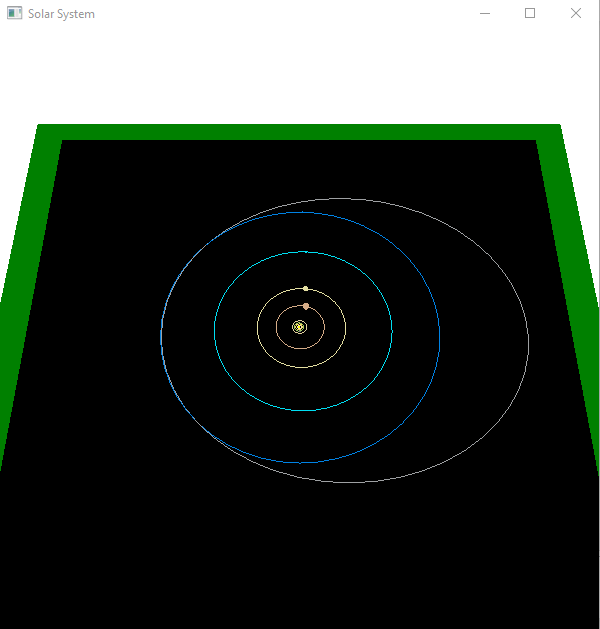